In [4]:
%load_ext autoreload
%autoreload 2
import importlib
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn as sk
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import NuSVC, SVC
from sklearn import metrics
from highcharts import Highchart


In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
import src.data_tools as dt 
import src.eda as eda
import src.jsaguiar as jsr
importlib.reload(eda)

<module 'src.eda' from '/home/romain/Documents/BackUp/Special/Projets/Code_IIA/Projet_4/DataScience/src/eda.py'>

In [7]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('onedork')

# Partie 1 Transformation des variables pour un modèle supervisé d'apprentissage

## EDA sur les variables initiales

### Chargement de la table depuis la base de données

Les lignes de code sont volontairement commentées pour avancer dans l'EDA.

In [5]:
Xy = pd.read_csv('Xy.csv', index_col='index')

### Identification de la cible

Notre cible est 0 pour les clients ayant remboursés leur crédit sans difficulté. Le 1 est pour les clients ayant eu un défaut de paiement.

Comme nous le voyons dans le graph en donut, nous avons 10 fois plus d'observation 0, que d'observation 1.

In [6]:
Xy['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [7]:
list_values = eda.generate_val_for_pie3D(Xy['TARGET'])
eda.piechart3D_cible(list_values, "Contenu de la Cible", "Nombre d'observations")

### Identification des variables catégorielles

Ci-dessous nous représentons la part de chaque variable. Nous allons regarder combien de colonne d'entier ont 2 valeurs uniques seulement car ils sont assimilables à des variables catégorielles transformées par OneHotEncoder (ou pandas get dummies) dès lors, puisqu'ils sont binaires. Ensuite nous transformerons les strings en variable catégorielle et nous regrouperont les colonnes d'entiers binaires et les tableaux de caractères en une catégorie binaires.

In [8]:
eda.piechart3D_cible([
    ['Integer', len(Xy.drop('TARGET', axis=1).select_dtypes('int').columns)],
    ['String', len(Xy.drop('TARGET', axis=1).select_dtypes('object').columns)],
    ['Flottant', len(Xy.drop('TARGET', axis=1).select_dtypes('float').columns)]
], "Contenu des features", 'Nombre de colonnes par type')

Nous réalisons une eda dans le tableau ci-dessous.

In [9]:
eda_df = eda.table(Xy.drop('TARGET', axis=1).select_dtypes(['float','int']))


dtypes: int64(78), float64(130), 

memory usage: 488.0 MB


Nombre de lignes: 307511


Nombre de valeurs non-nulles: 23593050


Nombre de valeurs nulles: 8388094



In [10]:
eda_df.head(3)

,columns,type,unique,mean,std,pct_null,pct>3iqr,non-nulls,max,min,outliers,negatives,kurtosis,skewness,mode,median
0,CNT_CHILDREN,int64,15,0.417052,0.722121,0.0,0.18,307511,19,0,10,0,7.904106,1.974604,0.0,0.0
1,AMT_INCOME_TOTAL,float64,2548,168797.919297,237123.146279,0.0,8.83,307511,117000000.0,25650.0,487,0,191786.554381,391.559654,135000.0,147150.0
2,AMT_CREDIT,float64,5603,599025.999706,402490.776996,0.0,2.15,307511,4050000.0,45000.0,0,0,1.934041,1.234778,450000.0,513531.0


Nous observons que les colonnes de string n'ont pas toutes la même modalité. Certaines en ont seulement 2, donc nous pouvons leur appliquer le labelEncoder à la place du one hot Encoder. Après avoir appliqué ces deux opérations, nous vérifierons la fréquence de ces modalités dans les nouvelles colonnes, pour éliminer les colonnes qui n'ont pas de forte fréquence supérieur à 30 % de modalité sur notre jeu de données.

In [11]:
print('Modalité par colonne\n\n')
for col in Xy.drop('TARGET', axis=1).select_dtypes('object').columns:
    print(col, '---->',Xy[col].unique().shape[0])

Modalité par colonne


NAME_CONTRACT_TYPE ----> 2
CODE_GENDER ----> 3
FLAG_OWN_CAR ----> 2
FLAG_OWN_REALTY ----> 2
NAME_TYPE_SUITE ----> 8
NAME_INCOME_TYPE ----> 8
NAME_EDUCATION_TYPE ----> 5
NAME_FAMILY_STATUS ----> 6
NAME_HOUSING_TYPE ----> 6
OCCUPATION_TYPE ----> 19
WEEKDAY_APPR_PROCESS_START ----> 7
ORGANIZATION_TYPE ----> 58
FONDKAPREMONT_MODE ----> 5
HOUSETYPE_MODE ----> 4
WALLSMATERIAL_MODE ----> 8
EMERGENCYSTATE_MODE ----> 3


De même dans ces colonnes font partie des colonnes binaires, catégorielles. Nous vérifierons leur fréquence en plus des colonnes issues de colonnes de type object ou plus clairement : string.

In [12]:
eda_df[eda_df['unique'] == 2]['columns'].tolist()

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [13]:
nb_str_int_bin = []
for col in Xy.drop('TARGET', axis=1).select_dtypes('int').columns:
    if Xy[col].nunique() == 2:
        nb_str_int_bin.append(col)
for col in Xy.drop('TARGET', axis=1).select_dtypes('object').columns:
    if Xy[col].nunique() == 2:
        nb_str_int_bin.append(col)
nb_str_int_bin

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [14]:
le = LabelEncoder()

In [15]:
for col in nb_str_int_bin:
    le.fit(Xy[col])
    Xy[col] = le.transform(Xy[col])

In [16]:
col_str_nbin = []
for col in Xy.drop('TARGET', axis=1).select_dtypes('object').columns:
    if Xy[col].nunique() > 2:
        col_str_nbin.append(col)
col_str_nbin

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [17]:
onehotencoder = pd.get_dummies(Xy[col_str_nbin])
nb_ohote = onehotencoder.shape[1]


In [18]:
col_ohote = onehotencoder.columns.tolist()


In [19]:
str_col =  Xy.drop('TARGET', axis=1).select_dtypes(['object']).columns
X_ohote= Xy.join(onehotencoder).drop(col_str_nbin, axis=1).copy()

In [20]:
X_ohote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 241 entries, TARGET to WALLSMATERIAL_MODE_Wooden
dtypes: float64(65), int64(44), uint8(132)
memory usage: 304.8 MB


In [21]:
col_ohote_bin = []
for col in X_ohote.drop('TARGET', axis=1).columns:
    if X_ohote[col].nunique() == 2:
        col_ohote_bin.append(col)
nb_ohote_bin = len(col_ohote_bin)
col_ohote_bin

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'CODE_GENDER_XNA',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_

In [22]:
col_ohote_int_bin = X_ohote.select_dtypes('int').drop('TARGET', axis=1).loc[:,X_ohote.select_dtypes('int').drop('TARGET', axis=1).nunique().eq(2).values.tolist()].columns.tolist()
col_ohote_int_nbin = X_ohote.select_dtypes('int').drop('TARGET', axis=1).loc[:,X_ohote.select_dtypes('int').drop('TARGET', axis=1).nunique().gt(2).values.tolist()].columns.tolist()
nb_ohote_int_bin = len(col_ohote_int_bin)
nb_ohote_int_nbin = len(col_ohote_int_nbin)

In [23]:
nb_ohote_float = len(X_ohote.drop('TARGET', axis=1).select_dtypes('float').columns)
col_ohote_float = X_ohote.drop('TARGET', axis=1).select_dtypes('float').columns.tolist()

Nous avons 65 variables continues, 8 variables discrètes et 167 variables catégorielles

In [24]:
eda.piechart3D_cible([
    ['Discretes', nb_ohote_int_nbin],
    ['Catégorielles', nb_ohote_bin],
    ['Continues', nb_ohote_float]
], "Contenu des features", 'Nombre de colonnes par nature de variable')

Vérifions la corrélation des données catégorielles

In [25]:
matcorr_ohote = X_ohote[col_ohote_bin + ['TARGET']].corr()['TARGET'].sort_values()

In [26]:
matcorr_ohote.head(3)
col_corr_head = matcorr_ohote.head(3).index.tolist()

In [27]:
matcorr_ohote.tail(6)[:-1]
col_corr_tail = matcorr_ohote.tail(6)[:-1].index.tolist()

Dans la cellule suivante nous calculons que la fréquence des colonnes catégorielles supérieures à 30 % équivaut à se concentrer sur 17 colonnes. Ceci afin de réduire le nombre de dimension de notre jeu de données.

In [28]:
# Colonnes catégorielles
#col_cat_temp = nb_str_bin + X_ohote.drop('TARGET', axis=1).loc[:,X_ohote.drop('TARGET', axis=1).nunique().eq(2).values.tolist()].columns.tolist()
#nb_col_freq = X_ohote[col_ohote_bin].sum().div(X_ohote.shape[0]).gt(0.3).sum()
col_cat_freq = X_ohote[col_ohote_bin].loc[:,X_ohote[col_ohote_bin].sum().div(X_ohote.shape[0]).gt(0.5).values.tolist()].columns.tolist()

In [29]:
col_cat = col_corr_head + col_corr_tail
for col in col_cat_freq:
    if col not in col_cat:
        col_cat.append(col)
col_cat

['NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Pensioner',
 'FLAG_EMP_PHONE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'REG_CITY_NOT_WORK_CITY',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE_Working',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_3',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_House / apartment']

In [30]:
X_corr_cat  = X_ohote[col_ohote_float + col_ohote_int_nbin + col_cat + ['TARGET']].copy()

In [31]:
eda.piechart3D_cible([
    ['Discretes', len(col_ohote_int_nbin)],
    ['Catégorielles', len(col_cat)],
    ['Continues', len(col_ohote_float)]
], "Contenu des features", 'Nombre de colonnes par nature de variable')

Nous avons donc réduit le nombre de dimension en réservant les colonnes les plus corrélées à la cible, et les moins clairsemées.

### Boxplots des distributions pour l'EDA

Nous avons créé une fonction qui prend le type de la colonne et un mot à l'intérieur du nom de sa colonne pour créer un boxplot de sa distribution.

Après quelques tests nous remarquons des valeurs aberrantes dans la colonne 'DAYS_EMPLOYED'. Nous les remplaçons par des données nulles et traçons son histogramme.

In [32]:
# Cette fonction prend en argument le cadre de données, une chaîne de caractère du nom des/de la colonne, et
# le type des données dans les colonnes.
eda.boxplot(X_corr_cat, 'DAYS', 'entiers')

In [33]:
X_corr_cat['DAYS_EMPLOYED_OUTLIERS'] = False
X_corr_cat.loc[X_corr_cat['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED_OUTLIERS'] = True

In [34]:
X_corr_cat.loc[X_corr_cat['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan
# Cette fonction fait change le type, à cause des valeurs nulles.

Nous remplaçons les valeurs nulles par des médianes avec le simple imputer de scikit-learn.

In [35]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(X_corr_cat[['DAYS_EMPLOYED']].to_numpy())
X_corr_cat[['DAYS_EMPLOYED']] = pd.DataFrame(imp_mean.transform(X_corr_cat[['DAYS_EMPLOYED']].to_numpy()),
                                          index=X_ohote.index, columns=['DAYS_EMPLOYED'])

In [36]:
eda.boxplot(X_corr_cat, 'DAYS', 'flottants')

Nous convertissons nos données dans le format optimal pour permettre l'eda programmée

In [37]:
col_bool = X_corr_cat.select_dtypes('bool').columns.tolist()#.astype('int')
X_corr_cat[col_bool] = X_corr_cat[col_bool].astype('int') 

In [38]:
eda_corr_cat_df = eda.table(X_corr_cat.drop('TARGET', axis=1))#.select_dtypes(['float','int']))


dtypes: int64(28), uint8(18), float64(132), 

memory usage: 1.117e+03 MB


Nombre de lignes: 307511


Nombre de valeurs non-nulles: 18980385


Nombre de valeurs nulles: 8388094



#### Nombre de valeurs nulles pour l'EDA

In [39]:
X_corr_cat.isnull().sum(axis=1).sum()

8388094

#### Représentation de l'EDA en tableau

La base application train comporte 307511 lignes

In [40]:
X_corr_cat.shape

(307511, 90)

Ci-dessous nous voyons le nombre de valeurs non-nulles pour chaque colonne.

In [41]:
eda_corr_cat_df['nb_nulls'] = X_corr_cat.shape[0] - eda_corr_cat_df['non-nulls']

In [42]:
eda_corr_cat_df.columns

Index(['columns', 'type', 'unique', 'mean', 'std', 'pct_null', 'pct>3iqr',
       'non-nulls', 'max', 'min', 'outliers', 'negatives', 'kurtosis',
       'skewness', 'mode', 'median', 'nb_nulls'],
      dtype='object')

In [43]:
# Cette fonction fonctionne avec les colonnes présentées ci-dessus pourvu qu'elles soient en numéraire
# column_plot(dataframe, 'column to parse', 'title', 'subtitle', 'yaxis')
eda.column_plot(eda_corr_cat_df, 'pct_null', 'Nombre de valeurs nulles', 'en %', 'Total des valeurs')

Comme aucune colonne n'a plus de 80% de valeurs nulles nous allons pouvoir appliqué un imputer sur le jeu de données afin de remplacer les valeurs nulles par des valeurs moyennées.

In [44]:
#imp_mean = IterativeImputer(random_state=0)
#imp_mean.fit(X_corr_cat)
#X_imp_mean = imp_mean.transform(X_corr_cat)

In [45]:
#from pickle import dump, load
#dump(X_imp_mean, open('../data/X_imp_mean_frozen.pkl','wb'))

In [46]:
X_imp_mean = pd.read_pickle('../data/X_imp_mean.pkl')

In [47]:
X_imp_mean = pd.DataFrame(X_imp_mean, columns=X_corr_cat.columns.tolist())

In [48]:
eda_imp_mean_df = eda.table(X_imp_mean.drop('TARGET', axis=1))


dtypes: float64(178), 

memory usage: 208.8 MB


Nombre de lignes: 307511


Nombre de valeurs non-nulles: 27368479


Nombre de valeurs nulles: 0



#### Corrélation avec la cible pour l'EDA

In [49]:
matcorr = X_imp_mean.corr()['TARGET'].sort_values()

In [50]:
matcorr.head()

EXT_SOURCE_3                           -0.200183
EXT_SOURCE_1                           -0.196202
EXT_SOURCE_2                           -0.160595
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
Name: TARGET, dtype: float64

In [51]:
matcorr.tail()

OWN_CAR_AGE                    0.059985
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.063368
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [52]:
col_corr = matcorr[-3:-1].index.values.tolist() + matcorr[0:3].index.values.tolist()[::-1]
print(matcorr[-3:-1].index.values.tolist())
print(matcorr[0:3].index.values.tolist()[::-1])

['DAYS_EMPLOYED', 'DAYS_BIRTH']
['EXT_SOURCE_2', 'EXT_SOURCE_1', 'EXT_SOURCE_3']


## Création de 3 nouvelles variables à partir des colonnes corrélées

Nous allons réalisé du Features Engineering sur nos 5 colonnes en considérant que le banquier pourra regénéré ces colonnes avec de nouveaux clients. En effet, les colonnes EXT_SOURCE sont des données de source financière externes déjà aggrégé d'une certaines façon dont nous ignorons les opérations.

In [53]:
from sklearn.preprocessing import PolynomialFeatures
for col in col_corr:
    X = X_imp_mean[[col]]
    poly = PolynomialFeatures(2)
    X = poly.fit_transform(X)
    X = pd.DataFrame(X,
                     columns=
                     [col + '_' + x.replace(' ', '_') for x in poly.get_feature_names()])
    X_imp_mean = X_imp_mean.join(X).copy()

In [54]:
matcorr_poly = X_imp_mean.corr()['TARGET'].sort_values()

In [55]:
matcorr_poly.loc[matcorr_poly.notnull()]

EXT_SOURCE_3_x0     -0.200183
EXT_SOURCE_3        -0.200183
EXT_SOURCE_1_x0     -0.196202
EXT_SOURCE_1        -0.196202
EXT_SOURCE_1_x0^2   -0.183133
                       ...   
DAYS_EMPLOYED_x0     0.063368
DAYS_EMPLOYED        0.063368
DAYS_BIRTH_x0        0.078239
DAYS_BIRTH           0.078239
TARGET               1.000000
Name: TARGET, Length: 100, dtype: float64

Nous obtenons plus de variables corrélées, en minimisant le risque de overfitting en ne gardant que des polynômes du second degrées.

In [56]:
col_to_drop = matcorr_poly.loc[matcorr_poly.isnull()].index.tolist()
X_imp_mean.drop(col_to_drop, axis=1, inplace=True)

## Création de 3 nouvelles variables à partir des données initiales.

Nous allons créé de nouvelles valeurs à partir des données initiales pos_cash, bureau et bureau balance et enfin balance de carte de crédit.

In [57]:
def onehotencoder(df):
    col_to_encode = df.select_dtypes('object').columns
    df_enc = pd.get_dummies(df[col_to_encode], columns=col_to_encode)
    col_encoded = [x for x in df_enc if x not in df]
    return df_enc, col_to_encode, col_encoded

### Variable pos_cash

In [58]:
def pos_var():
    pos = pd.read_csv('../data/POS_CASH_balance.csv')
    df_1, col_to_encode, col_encoded = onehotencoder(pos)
    df_tot = pos.join(df_1)
    aggregations = {'MONTHS_BALANCE': ['max'], 'SK_DPD': ['mean']}
    for col in col_encoded:
        aggregations.update({col: ['mean']})
    df_agg = df_tot.groupby('SK_ID_CURR').agg(aggregations)
    df_agg['SIZE'] = df_tot.groupby('SK_ID_CURR').agg('size')
    df_agg.columns = pd.Index(['POS_' + e[0].replace(' ', '_') + '_' + e[1].upper() for e in df_agg.columns.tolist() if 'ID' not in e])
    return df_agg

In [59]:
pos_agg = pos_var()

### Bureau 

In [60]:
bureau = pd.read_csv('../data/bureau.csv')
bureau_bal = pd.read_csv('../data/bureau_balance.csv')

In [61]:
b_b_ohe, bb_col_to_encode, bb_col_encoded = onehotencoder(bureau_bal)

In [62]:
aggregations = {'MONTHS_BALANCE': ['mean']}
for col in bb_col_encoded:
    aggregations.update({col: ['mean']})
b_b_ohe = bureau_bal.join(b_b_ohe)
df_b_b_agg = b_b_ohe.groupby('SK_ID_BUREAU').agg(aggregations)
df_b_b_agg['SIZE'] = b_b_ohe.groupby('SK_ID_BUREAU').agg('size')
df_b_b_agg.columns = pd.Index(['balance_' + e[0].replace(' ', '_') + '_' + e[1].upper() for e in df_b_b_agg.columns.tolist() if 'ID' not in e])


In [63]:
bureau = bureau.join(df_b_b_agg, how='left', on='SK_ID_BUREAU')

In [64]:
b_ohe, b_col_to_enc, b_col_encoded = onehotencoder(bureau)

In [65]:
bureau = bureau.drop(b_col_to_enc, axis=1).join(b_ohe)#.select_dtypes('object')

In [66]:
cat_aggregations = {}
for cat in bb_col_encoded: cat_aggregations['balance_' + cat + '_MEAN'] = ['mean'];
for cat in b_col_encoded: cat_aggregations[cat] = ['mean']

In [67]:
aggregations = {
 'DAYS_CREDIT': ['min','max', 'mean', 'var'],
 'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean'],
 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
 'DAYS_ENDDATE_FACT': ['max', 'mean'],
 'AMT_CREDIT_MAX_OVERDUE': ['mean'],
 'CNT_CREDIT_PROLONG': ['sum'],
 'AMT_CREDIT_SUM': ['min', 'max', 'mean'],
 'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean'],
 'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean'],
 'AMT_CREDIT_SUM_OVERDUE': ['mean'],
 'DAYS_CREDIT_UPDATE': ['mean'],
 'AMT_ANNUITY':['max','mean'] }
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['Bureau_' + e[0].replace(' ', '_') + '_' + e[1].upper() for e in bureau_agg.columns.tolist()])


In [68]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_BUREAU').agg(aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist() if 'ID' not in e])

closed = bureau[bureau['CREDIT_ACTIVE_Active'] == 0]
closed_agg = closed.groupby('SK_ID_BUREAU').agg(aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist() if 'ID' not in e])


In [69]:
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR').join(closed_agg, how='left', on='SK_ID_CURR')

### Carte de crédit (balance)

In [70]:
cb = pd.read_csv('../data/credit_card_balance.csv')

In [71]:
cb_ohe, cb_col_to_encode, cb_col_encoded = onehotencoder(cb)

In [72]:
cb = cb.drop(cb_col_to_encode, axis=1).join(cb_ohe).drop('SK_ID_PREV',axis=1)

In [73]:
aggregations = {}
for col in cb.columns:
    aggregations.update({col: ['min', 'max', 'mean', 'sum', 'var']})

In [74]:
cb_agg = cb.groupby('SK_ID_CURR').agg(aggregations)


In [75]:
cb_agg.columns = pd.Index(['CB_' + e[0] + "_" + e[1].upper() for e in cb_agg.columns.tolist() if 'ID' not in e])


# Jointures de nos variables

## Joignons toutes nos données en une seule table

In [76]:
X_to_norm = X_imp_mean.join(cb_agg, how='left').join(bureau_agg, how='left').join(pos_agg, how='left')

In [77]:
X_to_norm = X_to_norm.copy()

In [78]:
matcorr_to_norm = X_to_norm.corr()['TARGET'].sort_values()

In [79]:
matcorr_to_norm.loc[matcorr_to_norm.notnull()]

EXT_SOURCE_3_x0     -0.200183
EXT_SOURCE_3        -0.200183
EXT_SOURCE_1_x0     -0.196202
EXT_SOURCE_1        -0.196202
EXT_SOURCE_1_x0^2   -0.183133
                       ...   
DAYS_EMPLOYED        0.063368
DAYS_EMPLOYED_x0     0.063368
DAYS_BIRTH_x0        0.078239
DAYS_BIRTH           0.078239
TARGET               1.000000
Name: TARGET, Length: 303, dtype: float64

In [80]:
matcorr_to_norm.loc[matcorr_to_norm.notnull()].index.tolist()

['EXT_SOURCE_3_x0',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1_x0',
 'EXT_SOURCE_1',
 'EXT_SOURCE_1_x0^2',
 'EXT_SOURCE_3_x0^2',
 'EXT_SOURCE_2_x0',
 'EXT_SOURCE_2',
 'EXT_SOURCE_2_x0^2',
 'DAYS_BIRTH_x0^2',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED_x0^2',
 'NAME_INCOME_TYPE_Pensioner',
 'DAYS_EMPLOYED_OUTLIERS',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'AMT_CREDIT',
 'FLOORSMAX_MEDI',
 'NAME_HOUSING_TYPE_House / apartment',
 'TOTALAREA_MODE',
 'NAME_FAMILY_STATUS_Married',
 'HOUR_APPR_PROCESS_START',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_AVG',
 'ELEVATORS_AVG',
 'LIVINGAREA_MODE',
 'ELEVATORS_MEDI',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'ELEVATORS_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'APARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'CB_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'BASEMENTAREA_AVG',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'LIVINGAPARTMENTS_AVG',
 'BASEMENTAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'ENTRANCES_AVG',
 'ENTRANCES_MED

In [81]:
col_3v_nulls = X_to_norm.isnull().any().loc[X_to_norm.isnull().any() == True].index.tolist()

In [82]:
X = X_to_norm.copy()
cols = X.columns
n=0
for col in cols:
    pct_of_null = (X[col].shape[0] - X[col].count()) * 100 / X[col].shape[0]
    if pct_of_null > 40:
        n += 1
        X.drop(col, axis=1, inplace=True)

In [83]:
X.isnull().sum().sum()

1334388

In [6]:
#imp_mean = IterativeImputer(random_state=0)
#imp_mean.fit(X)
#X_cpt = imp_mean.transform(X)
#X_cpt = pd.DataFrame(X_cpt, columns=X.columns.tolist())
X_cpt = pd.read_pickle('../data/X_cpt.pkl')

In [85]:
matcorr_cpt = X_cpt.corr()['TARGET'].sort_values()

In [86]:
matcorr_cpt

EXT_SOURCE_3_x0     -0.200183
EXT_SOURCE_3        -0.200183
EXT_SOURCE_1_x0     -0.196202
EXT_SOURCE_1        -0.196202
EXT_SOURCE_1_x0^2   -0.183133
                       ...   
DAYS_EMPLOYED        0.063368
DAYS_EMPLOYED_x0     0.063368
DAYS_BIRTH_x0        0.078239
DAYS_BIRTH           0.078239
TARGET               1.000000
Name: TARGET, Length: 112, dtype: float64

## Sauvons nos données

In [87]:
#from pickle import dump, load
#dump(X_cpt, open('../data/X_cpt.pkl','wb'))
#dump(y, open('../data/y.pkl','wb'))

## Importance des features

In [9]:
X_imp_mean_frozen = pd.read_pickle('../data/X_imp_mean_frozen.pkl')

In [10]:
X, y = X_imp_mean_frozen.drop('TARGET', axis=1), X_imp_mean_frozen['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [11]:
print("CLF train accuracy: %0.8f" % clf.score(X_train, y_train))
print("CLF test accuracy: %0.8f" % clf.score(X_test, y_test))

CLF train accuracy: 0.91927001
CLF test accuracy: 0.91927469


In [12]:
dict_col = {}
for it, col in enumerate(X.columns.tolist()):
    dict_col.update({col:[clf.feature_importances_[it]]})


In [13]:
df_features_importance = pd.DataFrame().from_dict(dict_col)

In [14]:
df_features_importance =df_features_importance.T.reset_index().rename(columns={'index':'feature',0:'importance'})

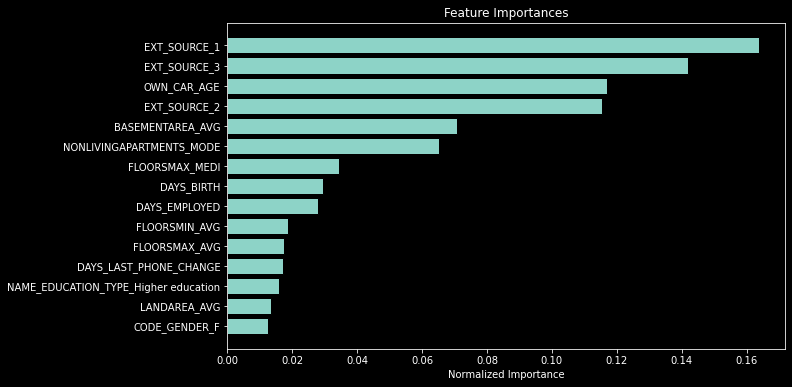

,index,feature,importance,importance_normalized
0,8,EXT_SOURCE_1,0.163725,0.163725
1,10,EXT_SOURCE_3,0.142077,0.142077
2,6,OWN_CAR_AGE,0.117092,0.117092
3,9,EXT_SOURCE_2,0.115391,0.115391
4,12,BASEMENTAREA_AVG,0.070882,0.070882
...,...,...,...,...
84,59,AMT_REQ_CREDIT_BUREAU_HOUR,0.000000,0.000000
85,27,YEARS_BEGINEXPLUATATION_MODE,0.000000,0.000000
86,26,BASEMENTAREA_MODE,0.000000,0.000000
87,39,APARTMENTS_MEDI,0.000000,0.000000


In [15]:
eda.plot_feature_importances(df_features_importance)

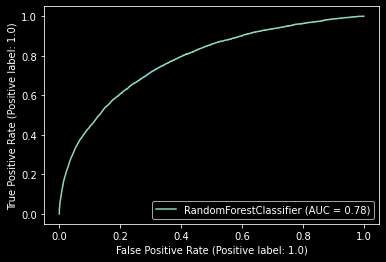

In [16]:
metrics.plot_roc_curve(clf, X_test, y_test)  

In [17]:
y_pred = clf.predict(X_test)
y_true = y_test
metrics.f1_score(y_true, y_pred, average='macro')

0.47896984073195525

## Calcul du modèle RandomForest avec les Features

In [97]:
X_cpt = pd.read_pickle('../data/X_cpt.pkl')
X, y = X_cpt.drop('TARGET', axis=1), X_cpt['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
scaler = MinMaxScaler(feature_range = (0, 1))
# Fit on the training data
scaler.fit(X_train)
# Transform both training and testing data
X_train = scaler.transform(X_train)
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [98]:
print("CLF train accuracy: %0.8f" % clf.score(X_train, y_train))
print("CLF test accuracy: %0.8f" % clf.score(X_test, y_test))

CLF train accuracy: 0.91927001
CLF test accuracy: 0.91927469


In [99]:
dict_col = {}
for it, col in enumerate(X.columns.tolist()):
    dict_col.update({col:[clf.feature_importances_[it]]})

In [100]:
df_features_importance = pd.DataFrame().from_dict(dict_col)

In [101]:
df_features_importance = df_features_importance.T.reset_index().rename(columns={'index':'feature', 0:'importance'})

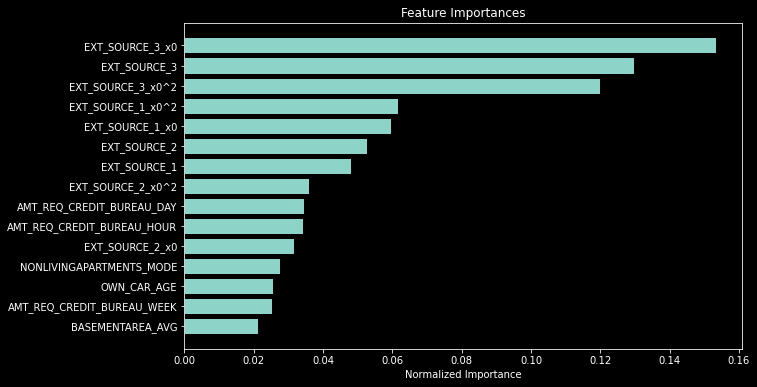

,index,feature,importance,importance_normalized
0,97,EXT_SOURCE_3_x0,0.153317,0.153317
1,10,EXT_SOURCE_3,0.129854,0.129854
2,98,EXT_SOURCE_3_x0^2,0.119966,0.119966
3,96,EXT_SOURCE_1_x0^2,0.061515,0.061515
4,95,EXT_SOURCE_1_x0,0.059638,0.059638
...,...,...,...,...
106,81,FLAG_OWN_REALTY,0.000000,0.000000
107,82,FLAG_MOBIL,0.000000,0.000000
108,83,FLAG_CONT_MOBILE,0.000000,0.000000
109,85,NAME_TYPE_SUITE_Unaccompanied,0.000000,0.000000


In [102]:
eda.plot_feature_importances(df_features_importance)

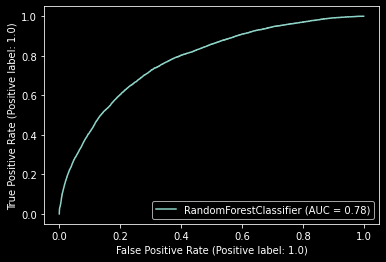

In [103]:
metrics.plot_roc_curve(clf, X_test, y_test)  

In [104]:
y_pred = clf.predict(X_test)
y_true = y_test
metrics.f1_score(y_true, y_pred, average='macro')

0.47896984073195525

La création des features n'a pas abouti à une amélioration du résultat.

## Selection des meilleures features

In [18]:
df_features_importance.sort_values('importance', ascending=False)[:10]['feature'].tolist()
col_importants = ['EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'OWN_CAR_AGE',
 'EXT_SOURCE_2',
 'BASEMENTAREA_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FLOORSMAX_MEDI',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLOORSMIN_AVG']

In [ ]:
X_imp_mean_frozen = pd.read_pickle('../data/X_imp_mean_frozen.pkl')
X, y = X_imp_mean_frozen[col_importants], X_cpt['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)
#scaler = MinMaxScaler(feature_range = (0, 1))
# Fit on the training data
scaler.fit(X_train)
# Transform both training and testing data
X_train = scaler.transform(X_train)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)


In [46]:
y_pred = clf.predict(X_test)
y_true = y_test
metrics.f1_score(y_true, y_pred, average='macro')

0.47896984073195525

# Création de Features

In [11]:
# Age information into a separate dataframe
X_imp_mean_frozen = pd.read_pickle('../data/X_imp_mean_frozen.pkl')

age_data = X_imp_mean_frozen[['TARGET', 'DAYS_BIRTH']].copy() 
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], 
                                  bins = np.linspace(20, 70, num = 11))

age_data.loc[age_data['TARGET'] == 1]['YEARS_BINNED'].describe()

count            24825
unique              10
top       (30.0, 35.0]
freq              4055
Name: YEARS_BINNED, dtype: object

In [12]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


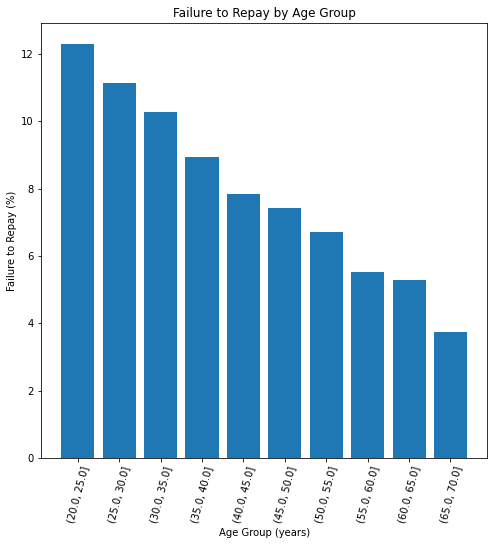

In [13]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); 
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [14]:
amt_credit_data = X_imp_mean_frozen[['TARGET', 'AMT_CREDIT']].copy() 
amt_max = amt_credit_data['AMT_CREDIT'].max()
amt_min = amt_credit_data['AMT_CREDIT'].min()

In [15]:
amt_credit_data['CREDIT_BINNED'] = pd.cut(amt_credit_data['AMT_CREDIT'], 
                                  bins = np.linspace(amt_min, amt_max, num = 11))
amt_credit_data

,TARGET,AMT_CREDIT,CREDIT_BINNED
0,1.0,406597.5,"(45000.0, 445500.0]"
1,0.0,1293502.5,"(1246500.0, 1647000.0]"
2,0.0,135000.0,"(45000.0, 445500.0]"
3,0.0,312682.5,"(45000.0, 445500.0]"
4,0.0,513000.0,"(445500.0, 846000.0]"
...,...,...,...
307506,0.0,254700.0,"(45000.0, 445500.0]"
307507,0.0,269550.0,"(45000.0, 445500.0]"
307508,0.0,677664.0,"(445500.0, 846000.0]"
307509,1.0,370107.0,"(45000.0, 445500.0]"


In [16]:
enc = OneHotEncoder(handle_unknown='ignore')
X = amt_credit_data['CREDIT_BINNED']
enc.fit(X)

enc.categories_

enc.transform([['Female', 1], ['Male', 4]]).toarray()


enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])


enc.get_feature_names(['gender', 'group'])
amt_credit_data

,TARGET,AMT_CREDIT,CREDIT_BINNED
0,1.0,406597.5,"(45000.0, 445500.0]"
1,0.0,1293502.5,"(1246500.0, 1647000.0]"
2,0.0,135000.0,"(45000.0, 445500.0]"
3,0.0,312682.5,"(45000.0, 445500.0]"
4,0.0,513000.0,"(445500.0, 846000.0]"
...,...,...,...
307506,0.0,254700.0,"(45000.0, 445500.0]"
307507,0.0,269550.0,"(45000.0, 445500.0]"
307508,0.0,677664.0,"(445500.0, 846000.0]"
307509,1.0,370107.0,"(45000.0, 445500.0]"


In [46]:
amt_credit_data_groups  = amt_credit_data.groupby('CREDIT_BINNED').mean()
amt_credit_data_groups

,TARGET,AMT_CREDIT
CREDIT_BINNED,,
"(45000.0, 445500.0]",0.082256,2.509098e+05
"(445500.0, 846000.0]",0.091237,6.142435e+05
"(846000.0, 1246500.0]",0.065833,1.017797e+06
"(1246500.0, 1647000.0]",0.056319,1.384341e+06
"(1647000.0, 2047500.0]",0.045595,1.826565e+06
"(2047500.0, 2448000.0]",0.025243,2.218472e+06
"(2448000.0, 2848500.0]",0.032258,2.549020e+06
"(2848500.0, 3249000.0]",0.086957,3.035340e+06
"(3249000.0, 3649500.0]",0.000000,3.413981e+06


In [99]:
round(stats.pearsonr(range(1,11),amt_credit_data_groups['AMT_CREDIT'].values.tolist())[0],4)

0.9986

In [133]:
round(np.cov(amt_credit_data_groups['AMT_CREDIT'], range(1,11))[0][1],2)

3751104.91

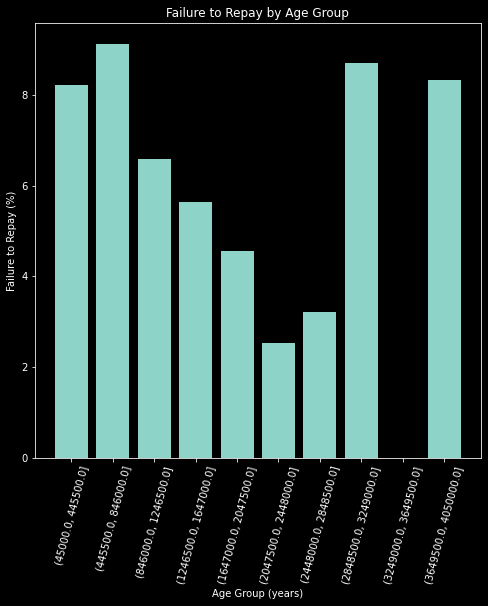

In [47]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(amt_credit_data_groups.index.astype(str), 100 * amt_credit_data_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); 
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [17]:
def grouper(num):
    num += 1
    X_imp_mean_frozen = pd.read_pickle('../data/X_imp_mean_frozen.pkl')
    for col in X_imp_mean_frozen.select_dtypes('float').drop('TARGET', axis=1).columns.tolist():
        col_data = X_imp_mean_frozen[['TARGET', col]].copy() 
        col_max = col_data[col].max()
        col_min = col_data[col].min()
        col_data[col + '_BINNED'] = pd.cut(col_data[col], 
                                      bins = np.linspace(col_min, col_max, num = num))
        col_data_groups  = col_data.groupby(col + '_BINNED').mean()
        col_data_groups[col] = col_data_groups[col].fillna(0)#.values.tolist())
        r2 = round(stats.pearsonr(range(1,num),
                             col_data_groups[col].values.tolist())[0],4)
        #cov = round(pd.DataFrame(range(1,11),col_data_groups[col]).cov().values[0][0], 2)
        cov = round(np.cov(col_data_groups[col], range(1,num))[0][1],2)
        plt.figure(figsize = (8, 8))

        # Graph the age bins and the average of the target as a bar plot
        plt.bar(col_data_groups.index.astype(str), 100 * col_data_groups['TARGET'])

        # Plot labeling
        plt.xticks(rotation = 75); plt.xlabel(col + ' Group (years)'); 
        plt.ylabel('Failure to Repay (%)')
        plt.title('Failure to Repay by ' + col);
        plt.tight_layout()
        plt.savefig('../img/features/'+ str(num - 1) + '_' + str(cov).replace('.', ',') + 'fig_' + col.replace(' ', '_')[:20] + '.jpg')

/tmp/ipykernel_18157/963808333.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (8, 8))


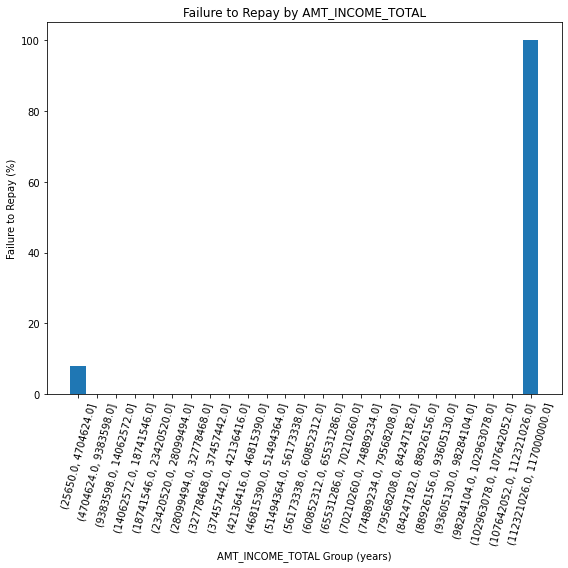

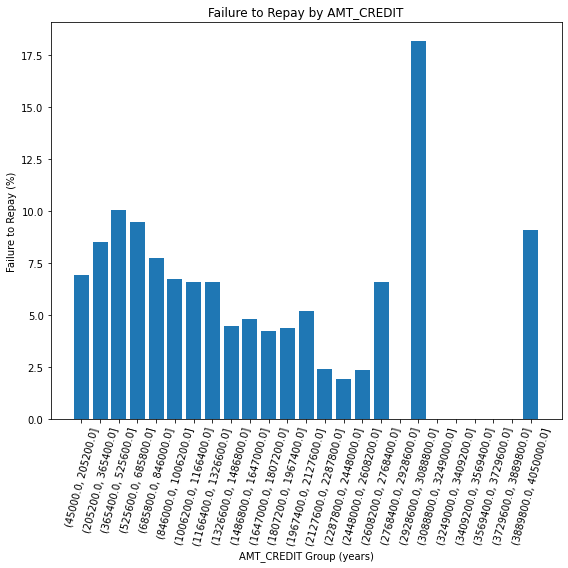

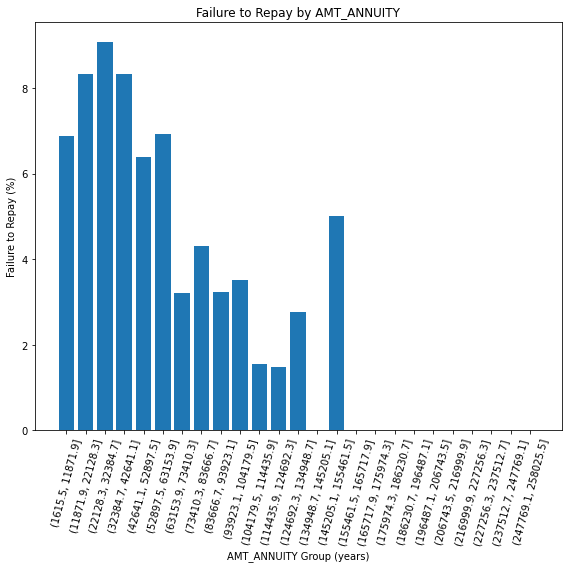

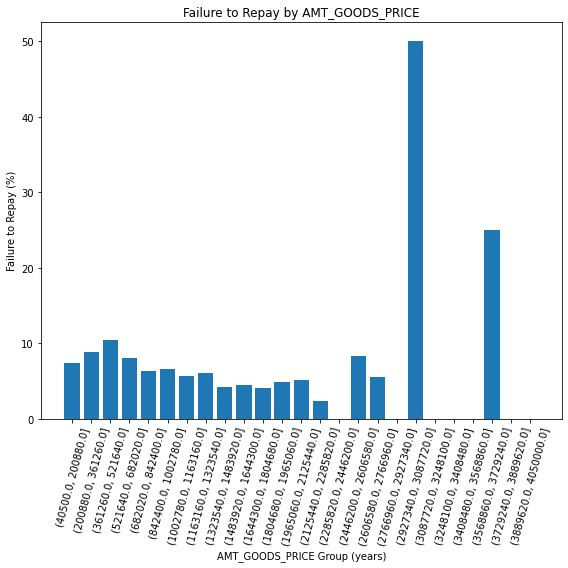

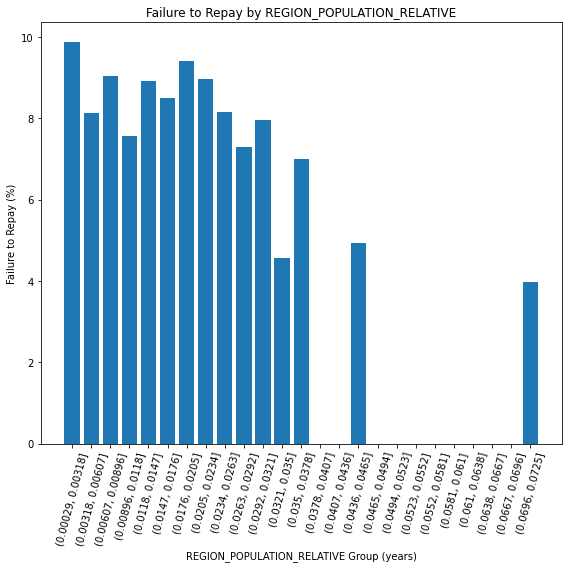

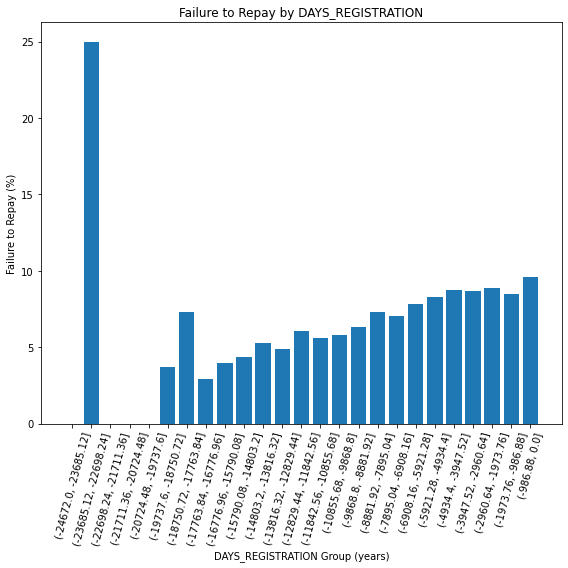

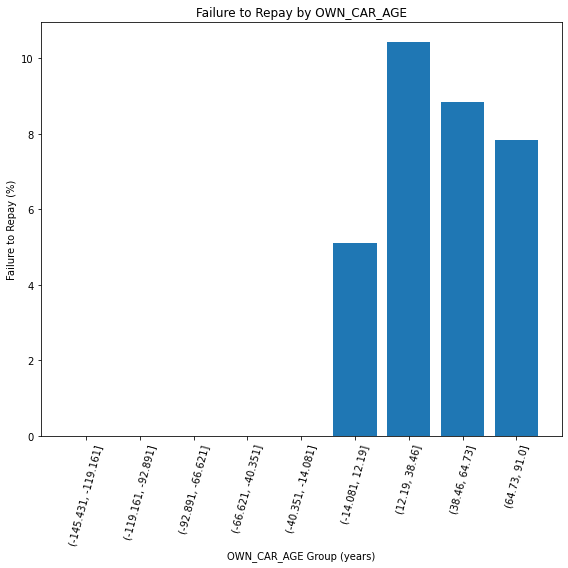

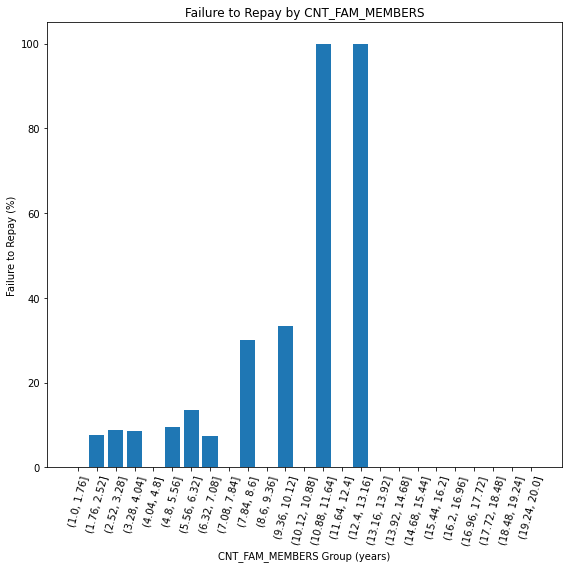

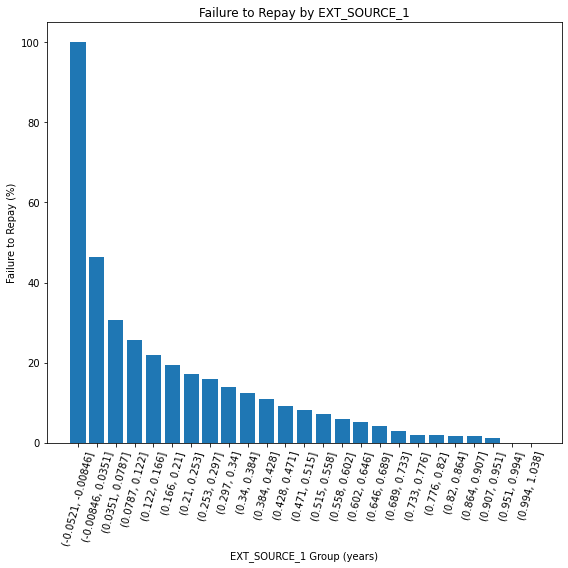

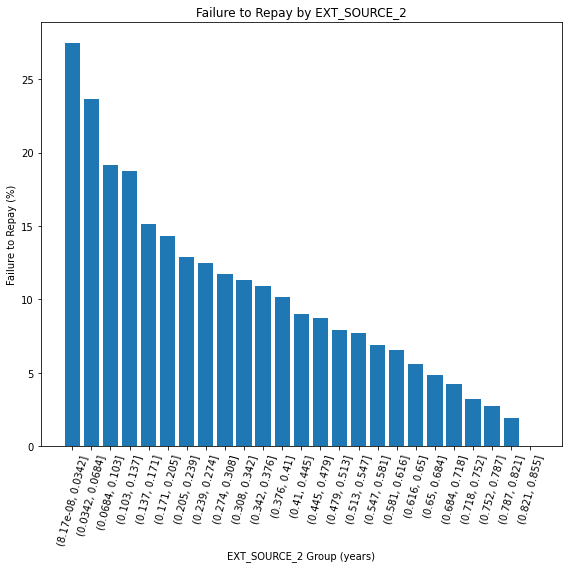

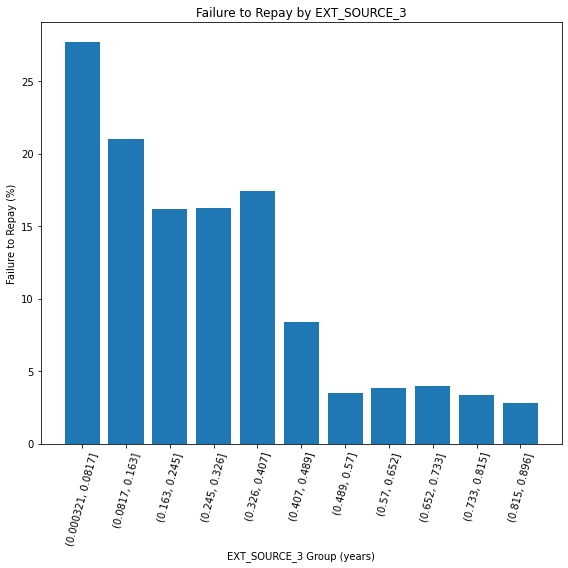

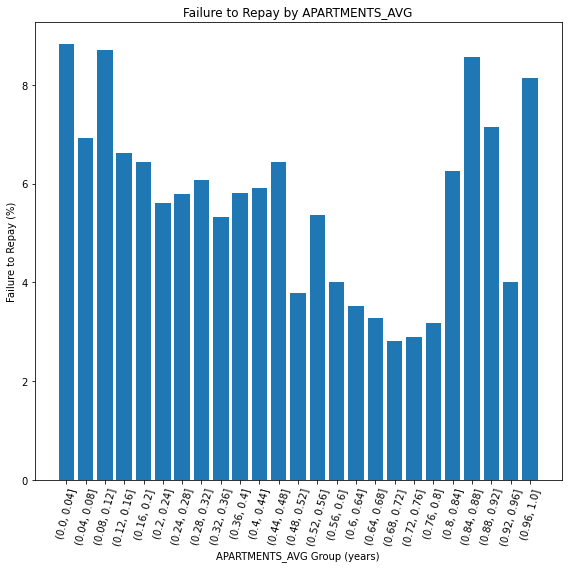

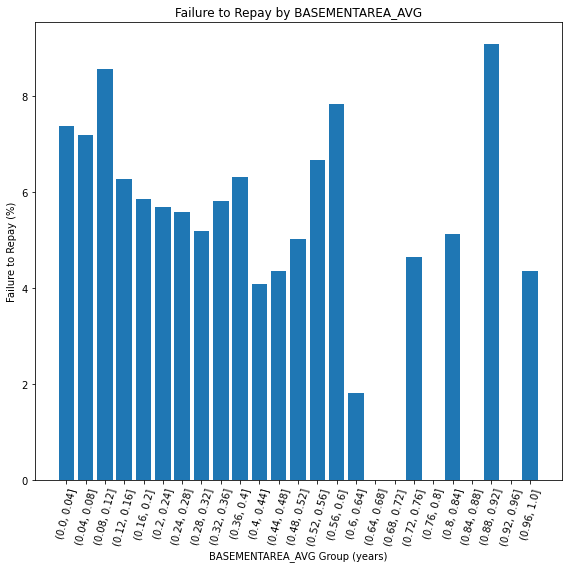

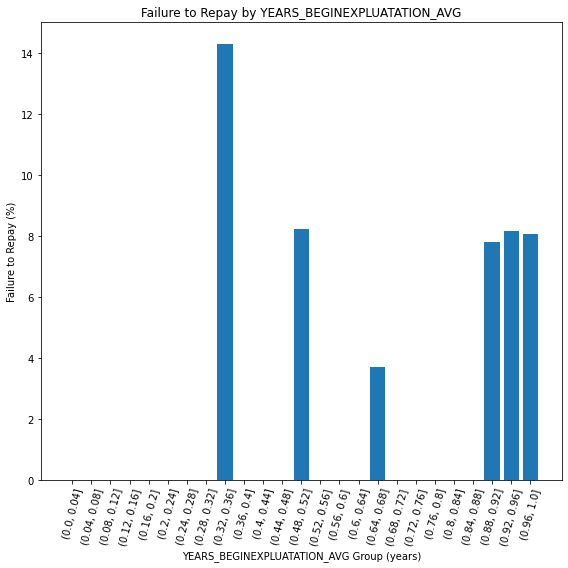

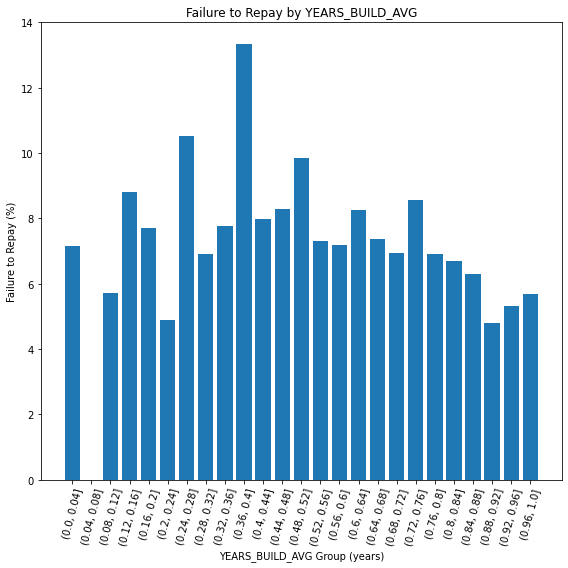

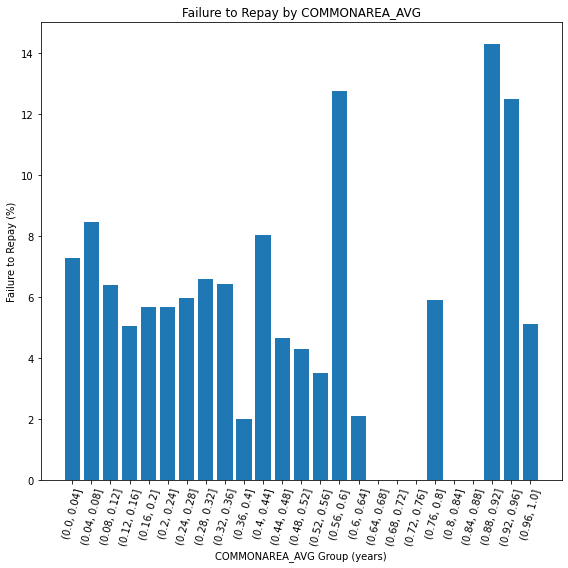

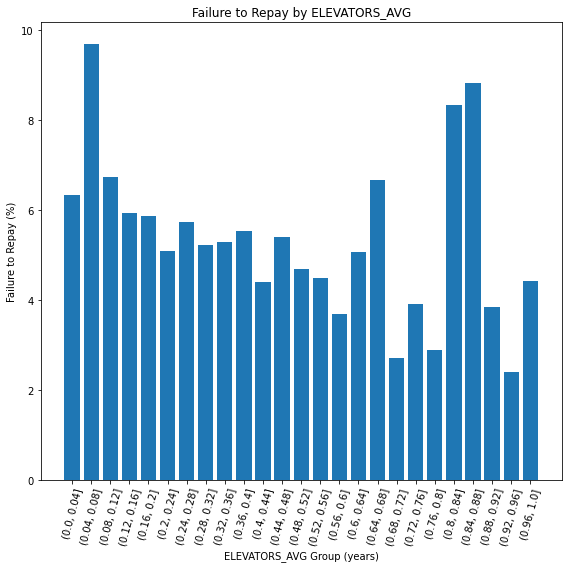

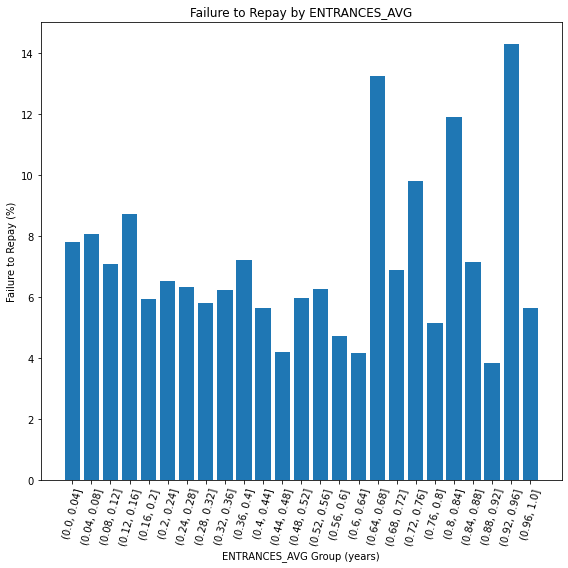

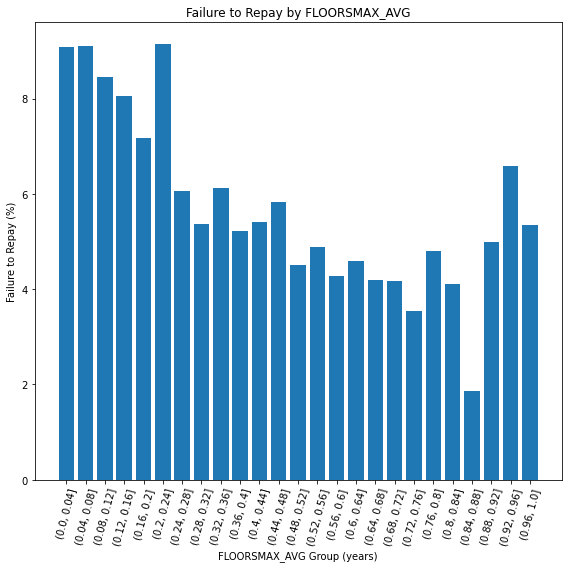

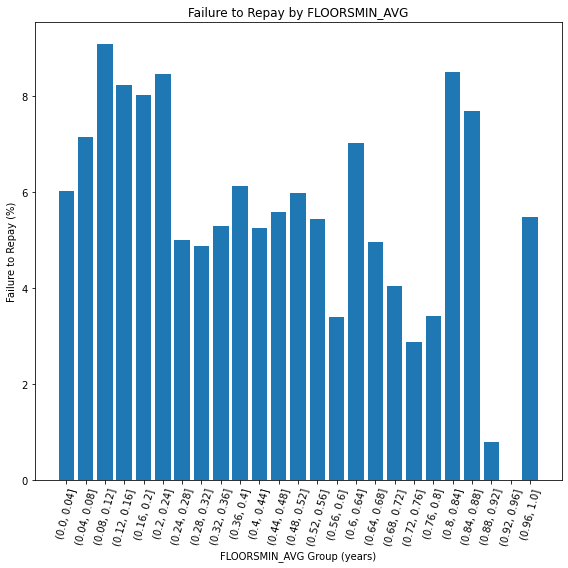

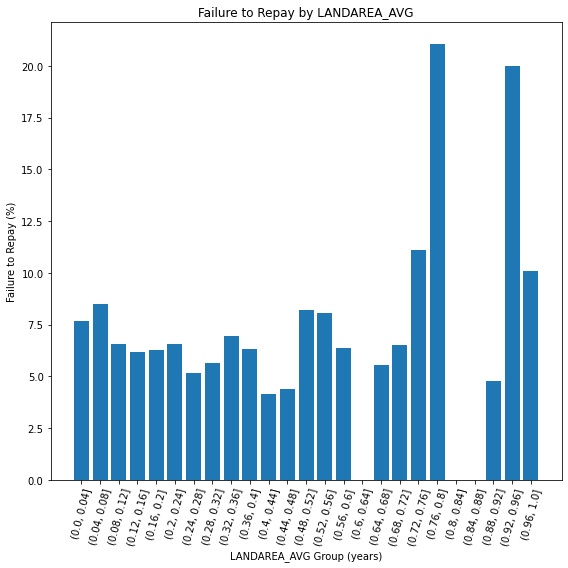

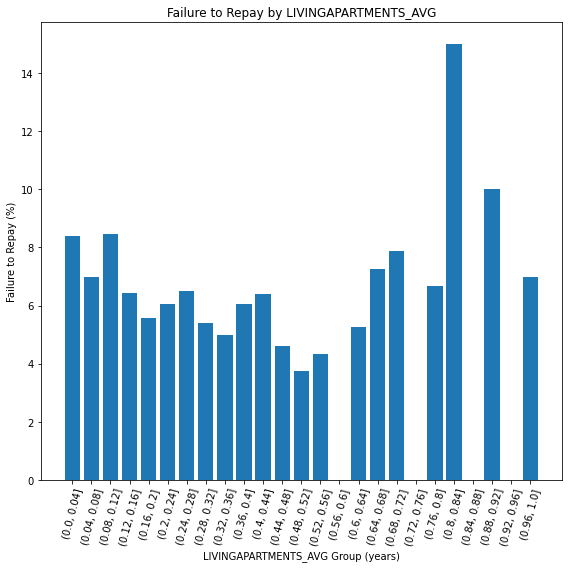

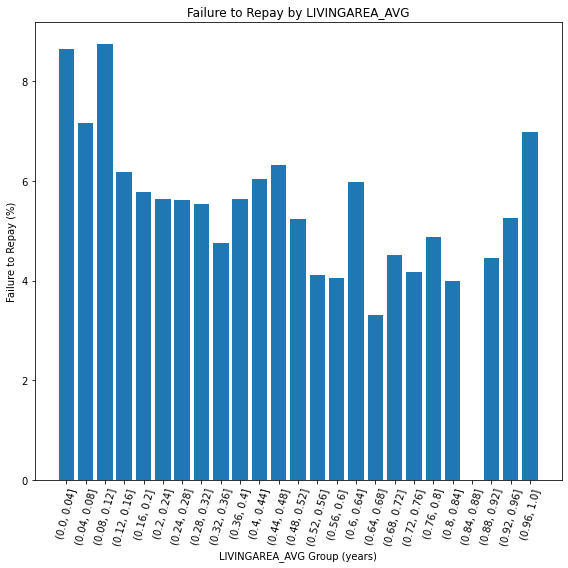

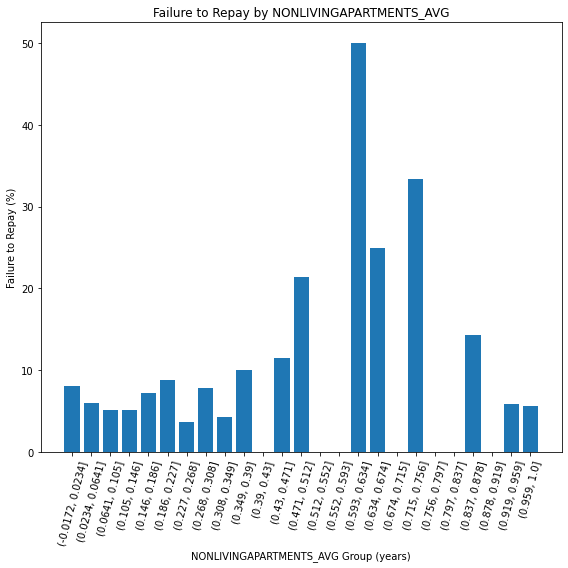

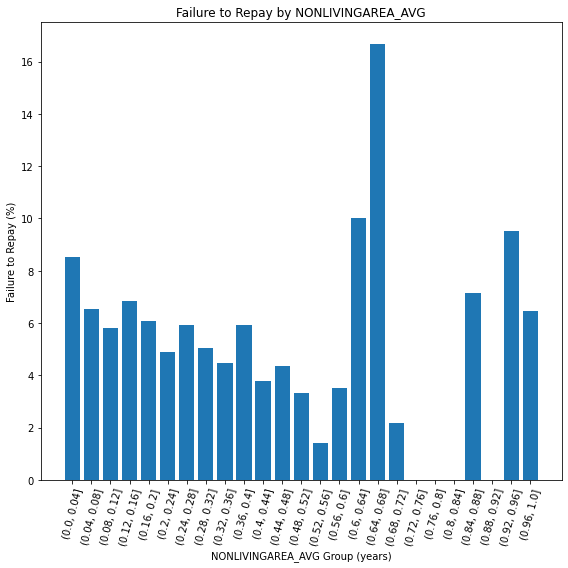

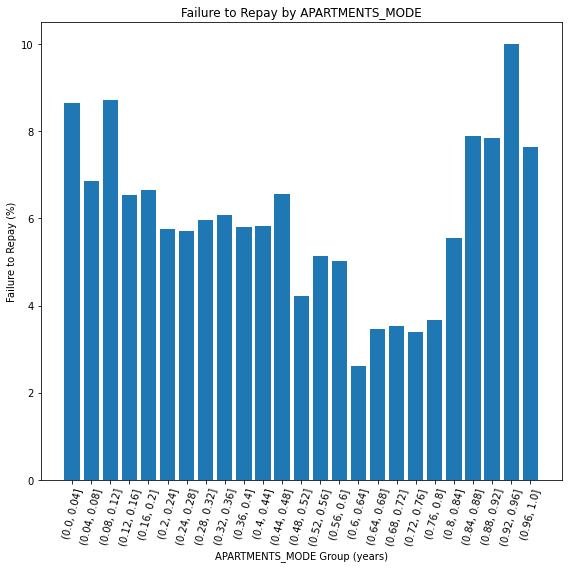

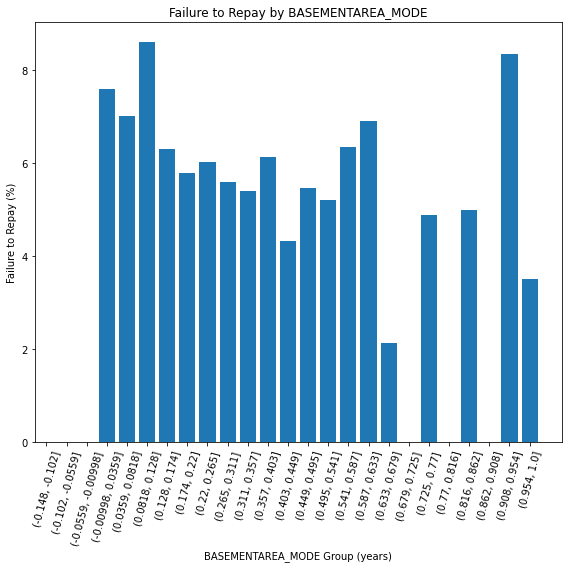

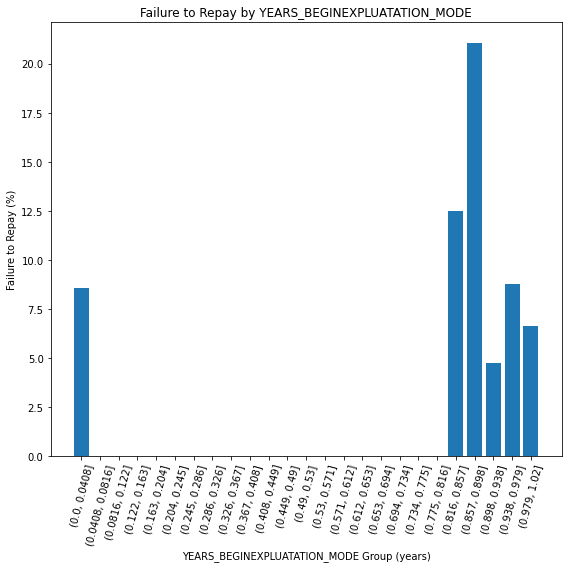

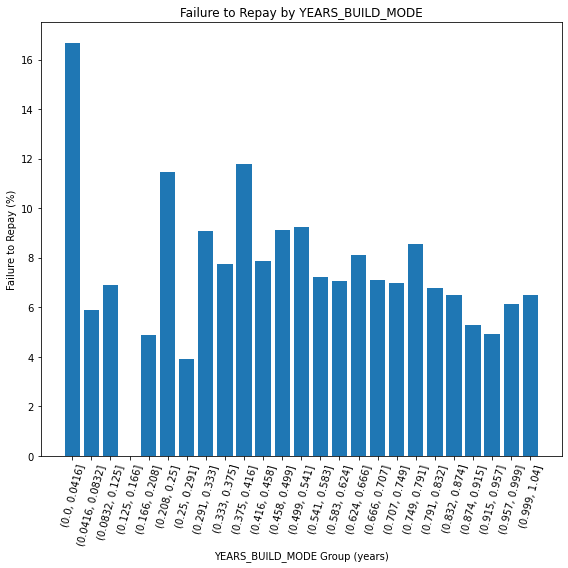

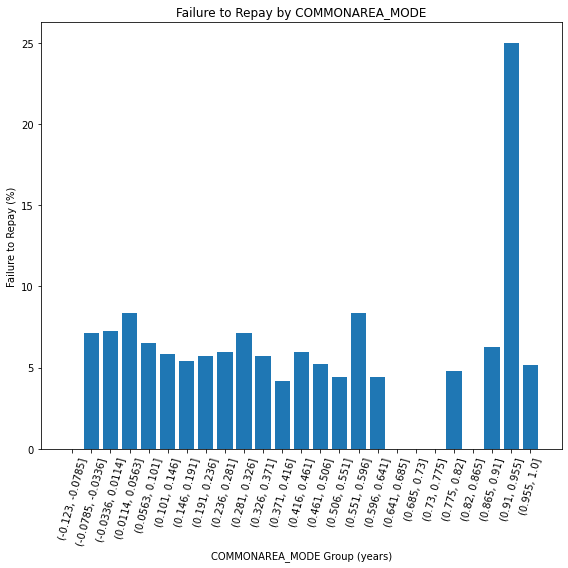

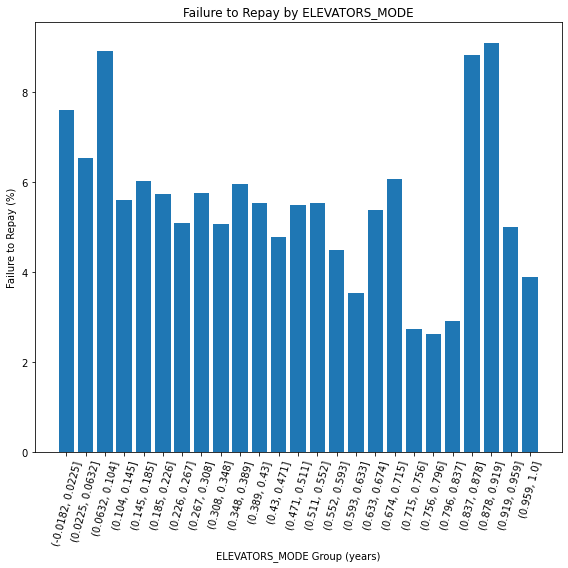

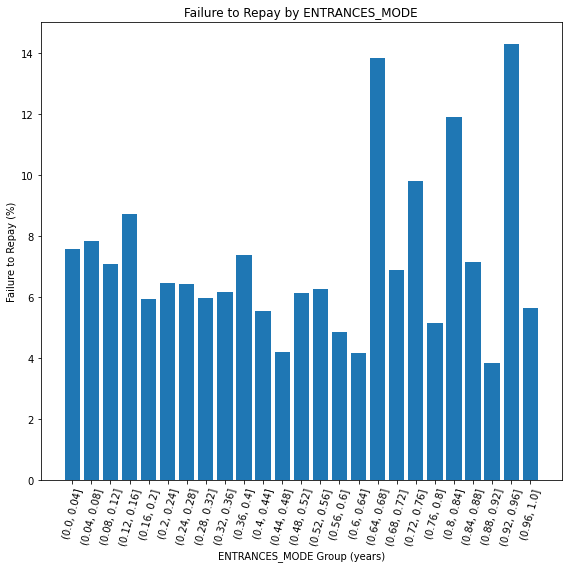

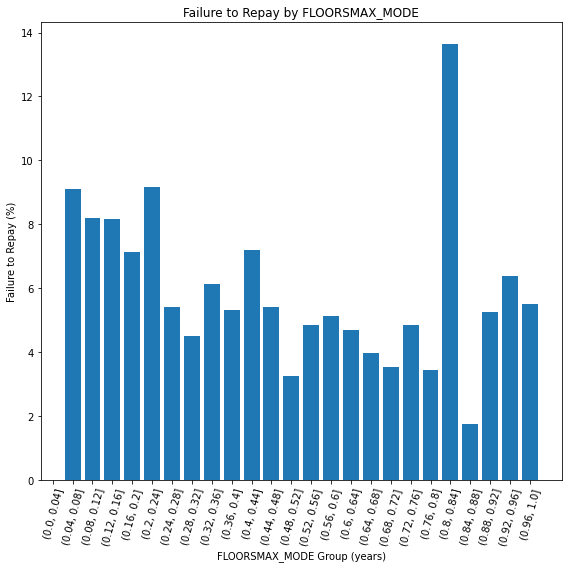

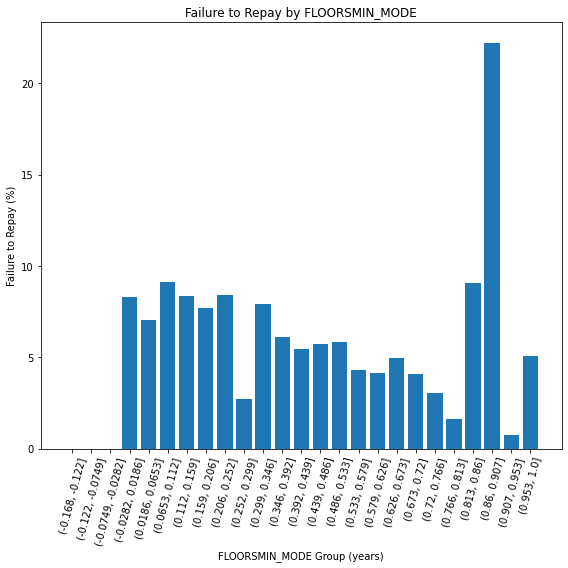

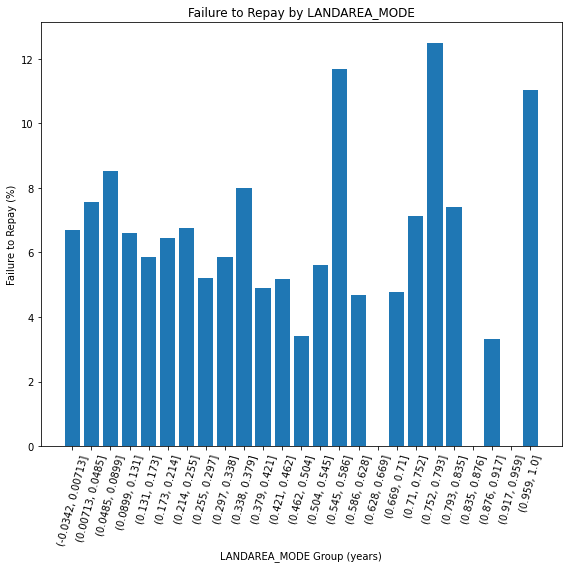

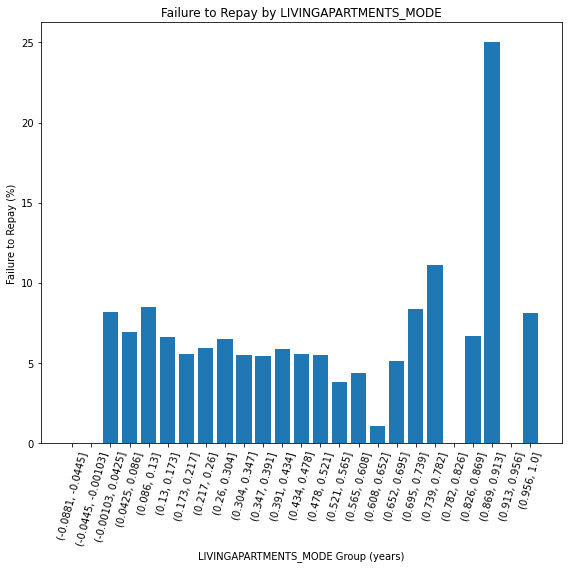

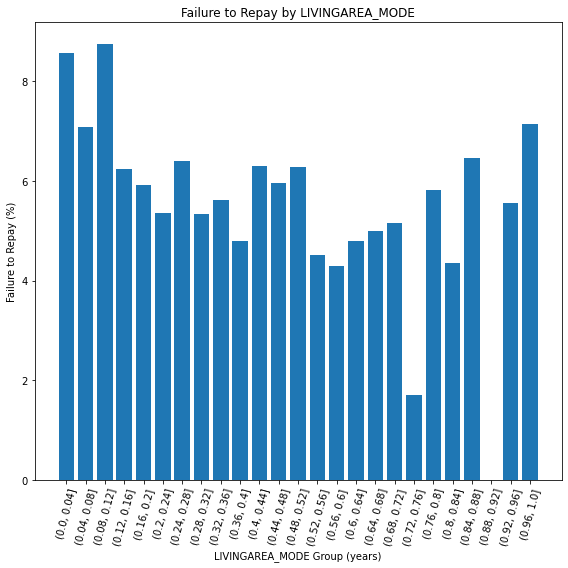

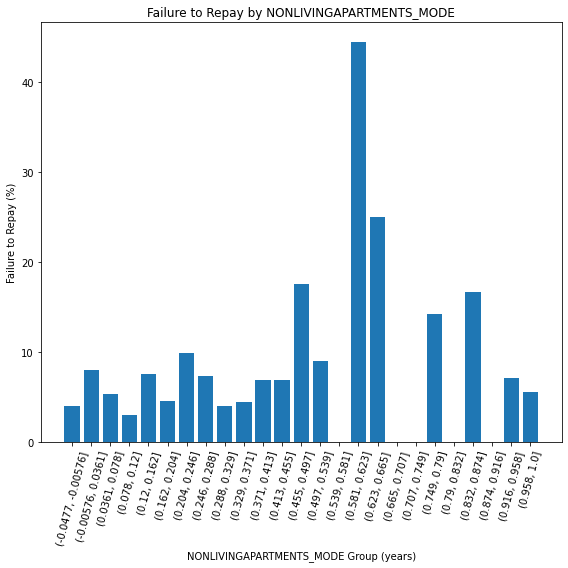

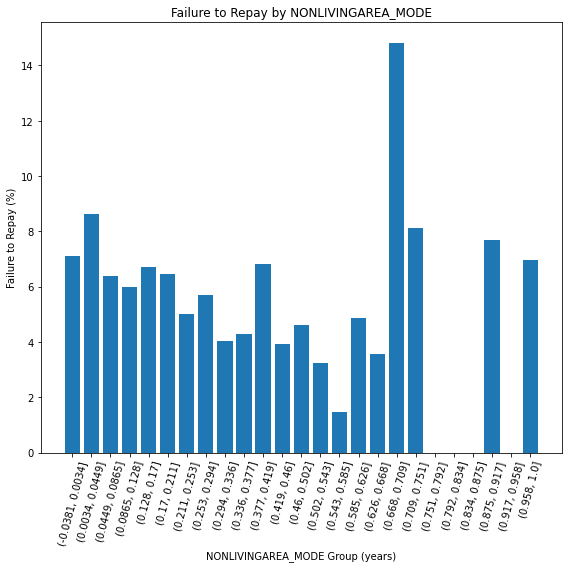

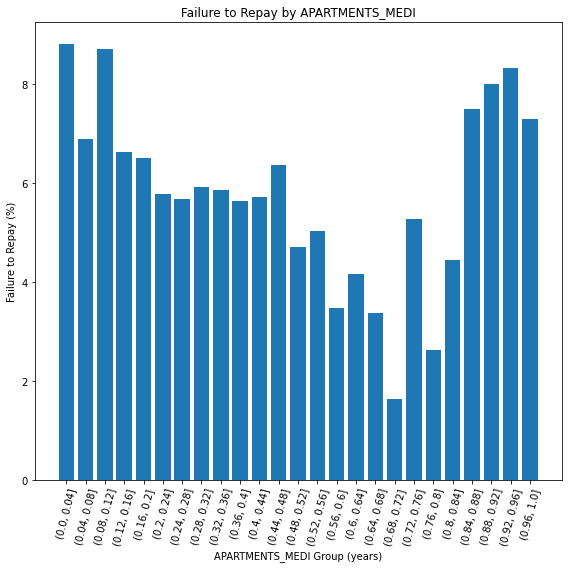

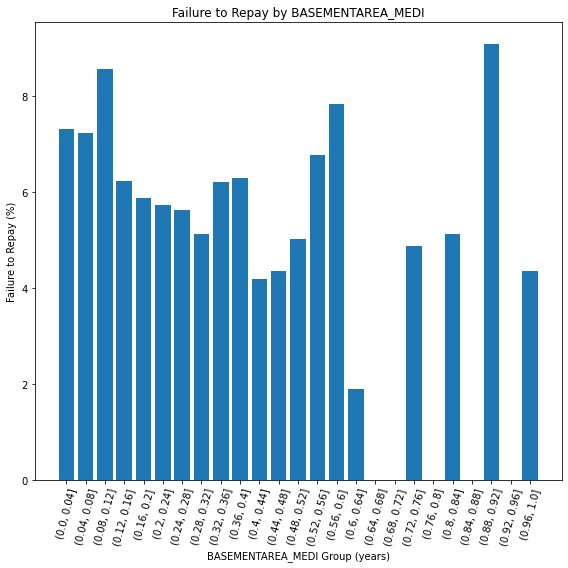

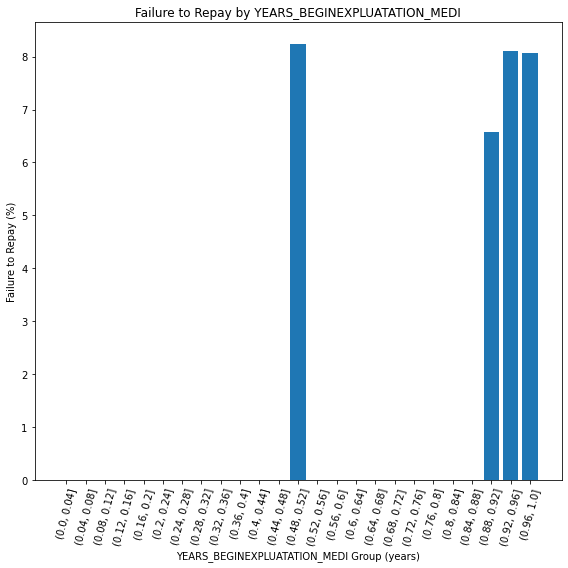

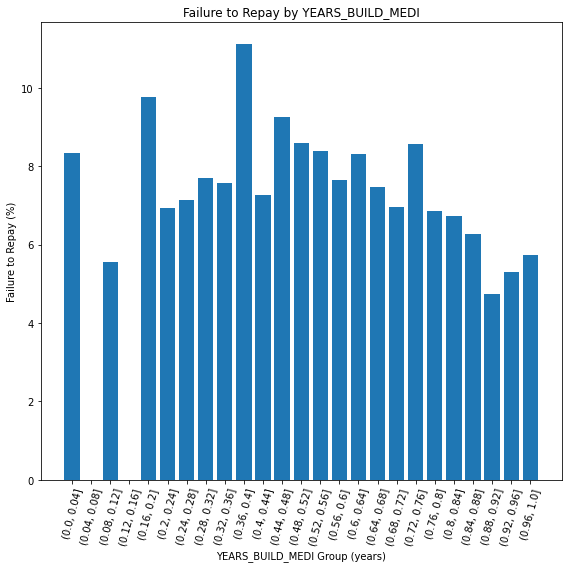

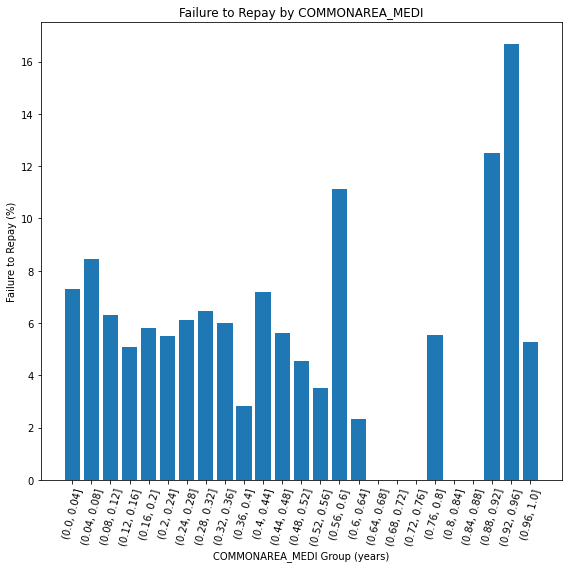

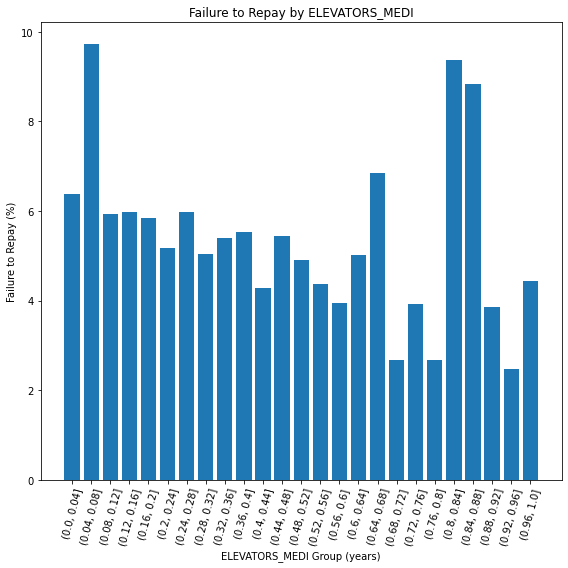

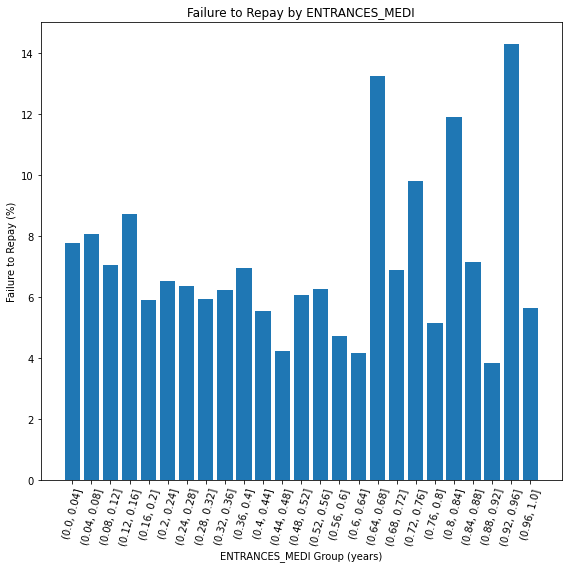

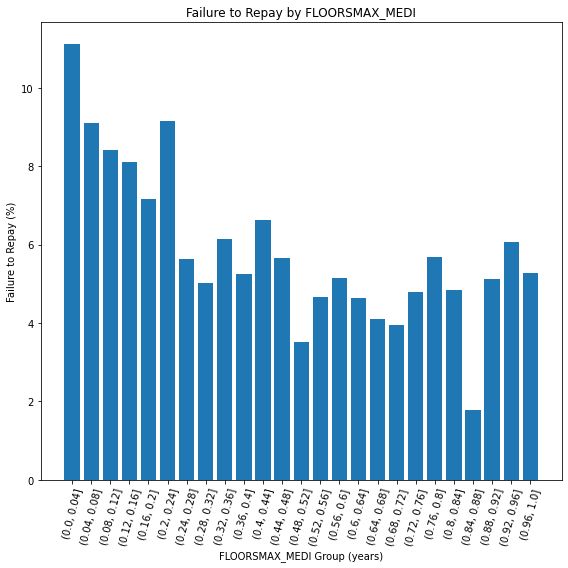

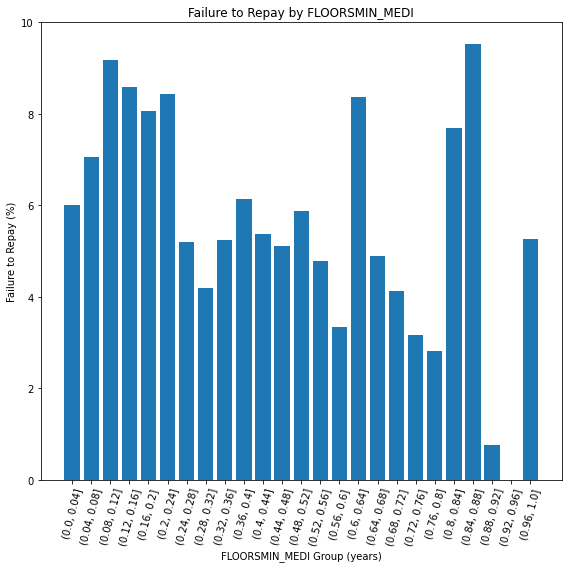

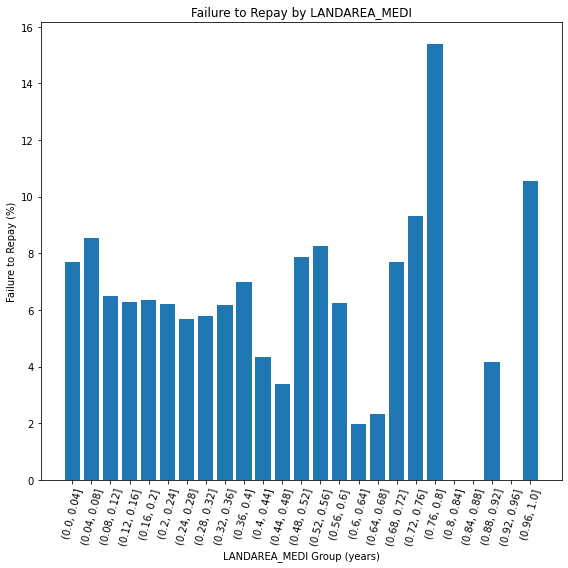

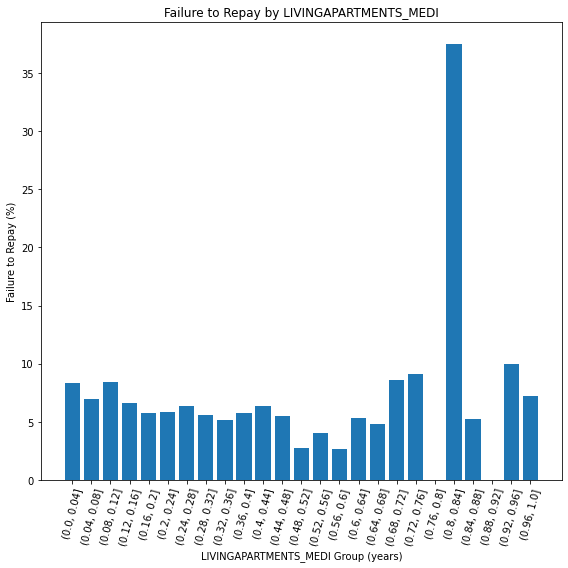

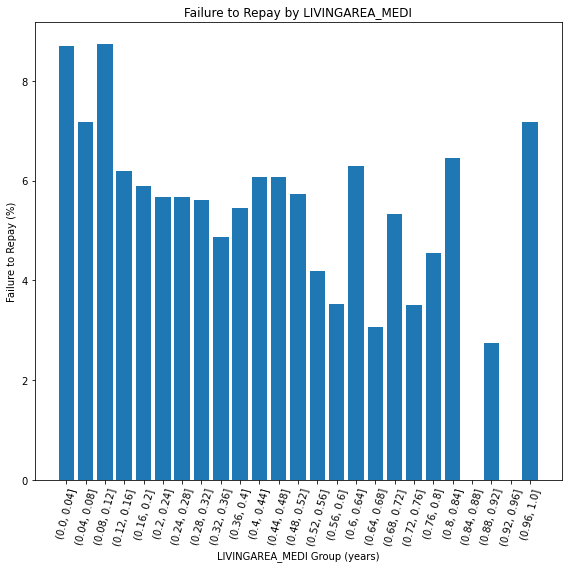

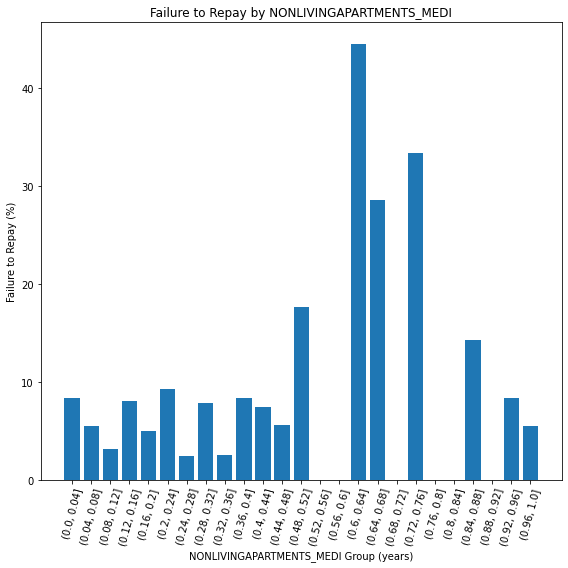

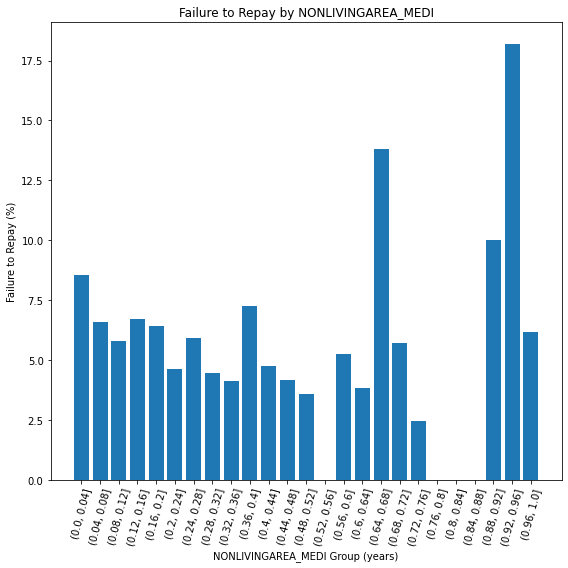

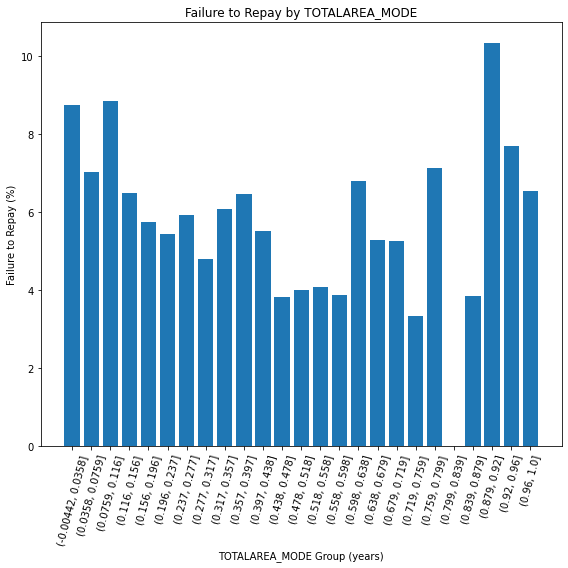

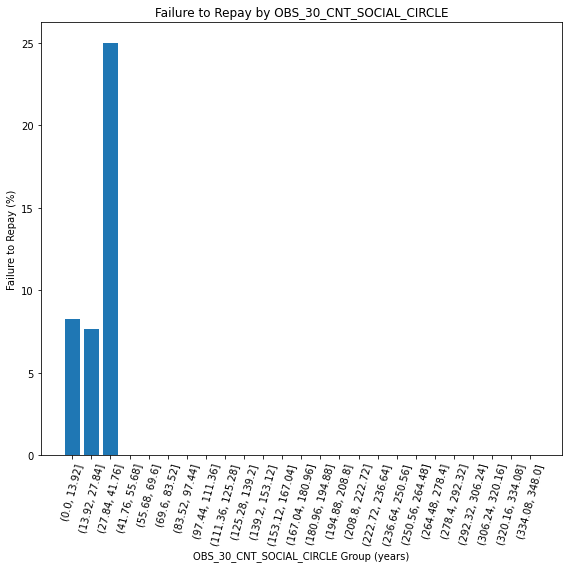

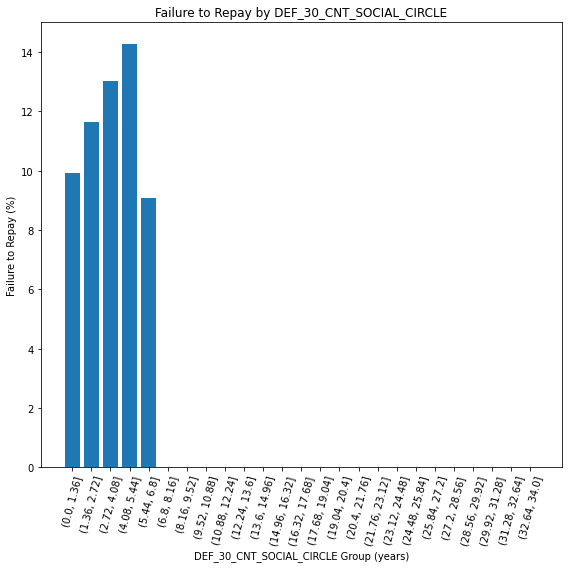

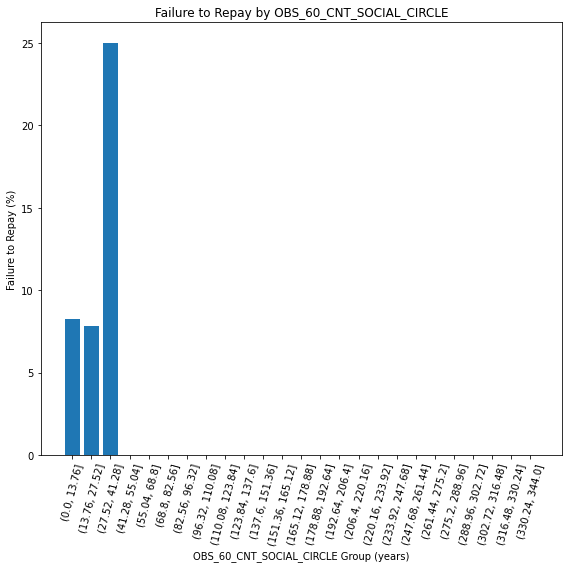

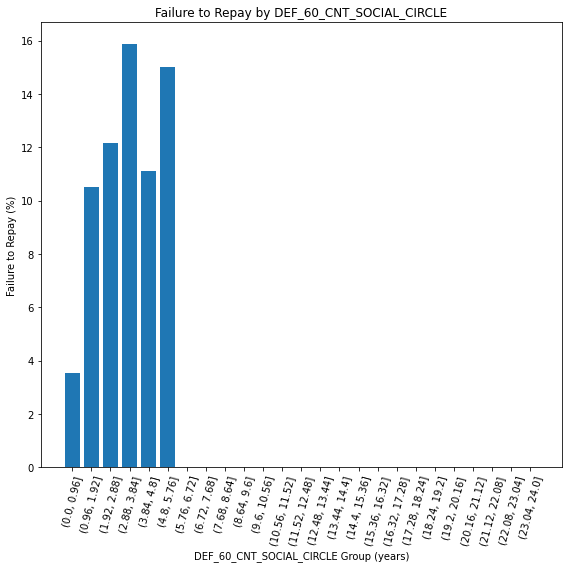

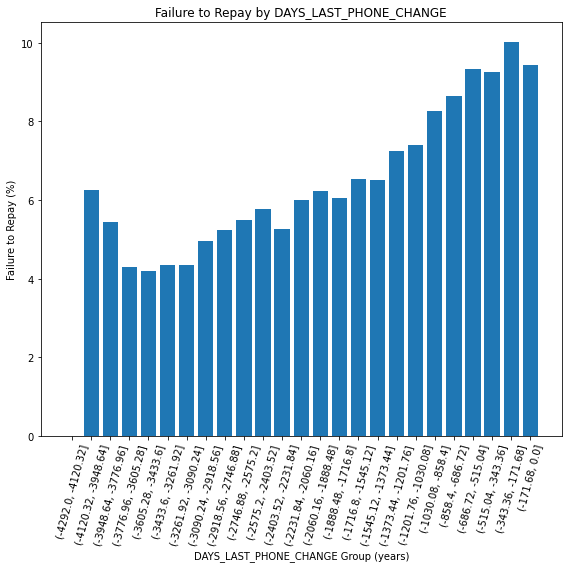

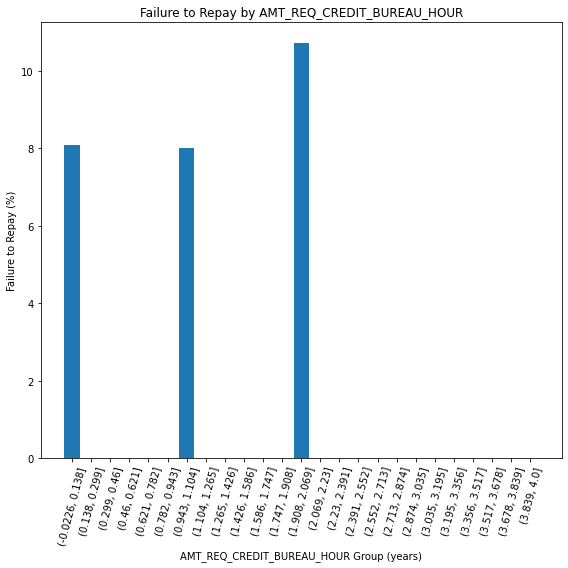

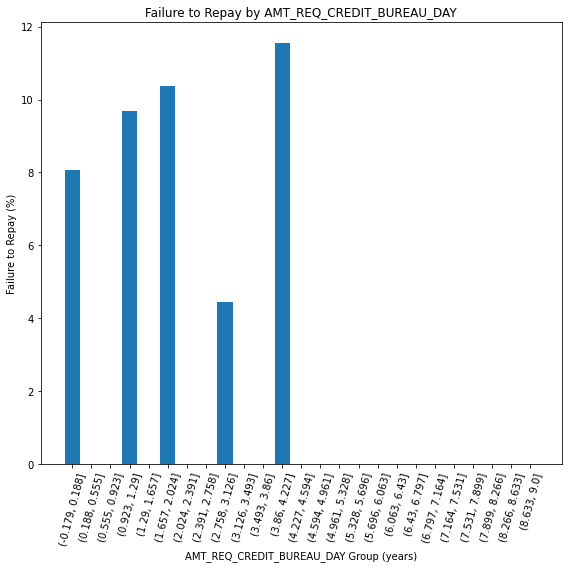

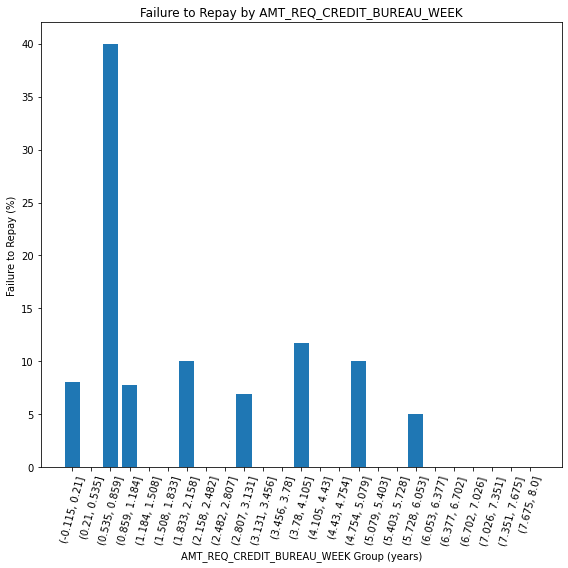

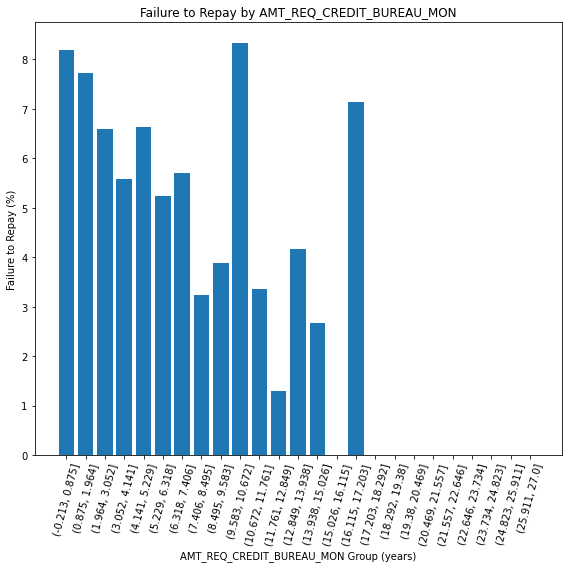

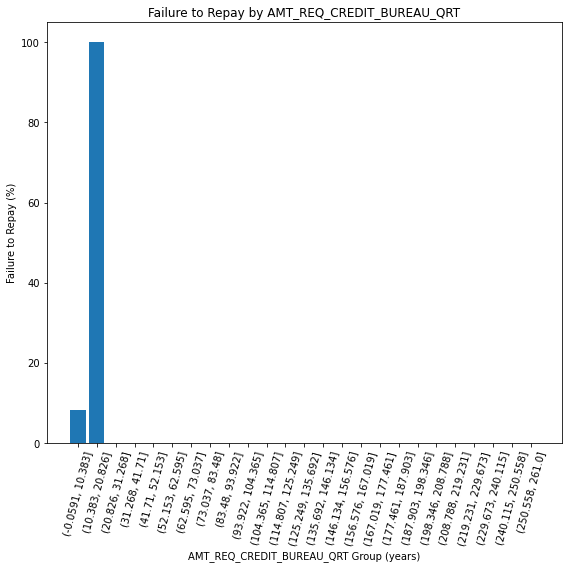

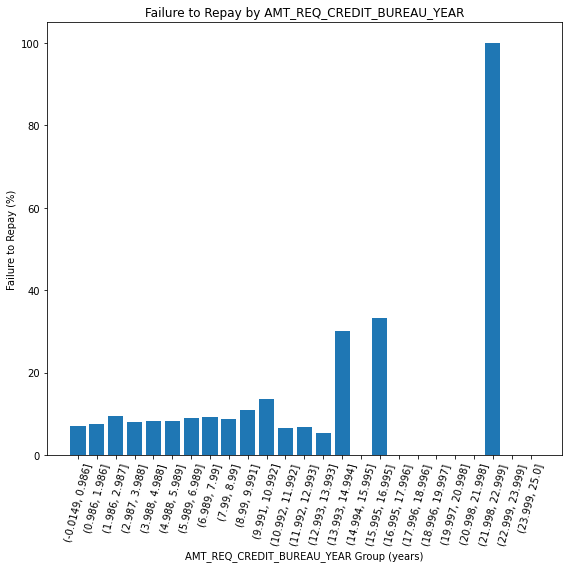

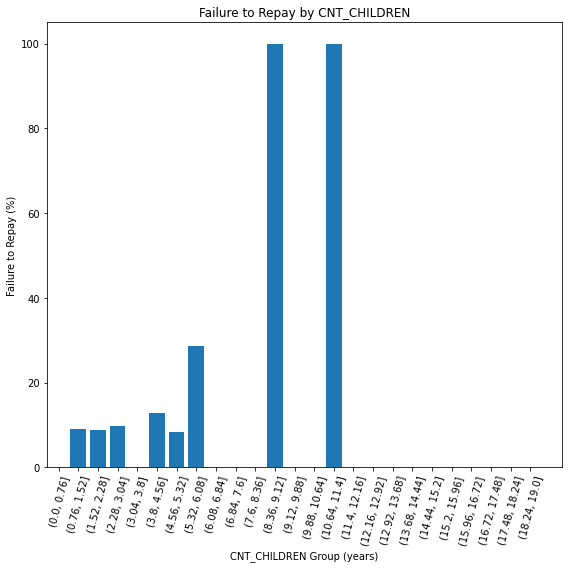

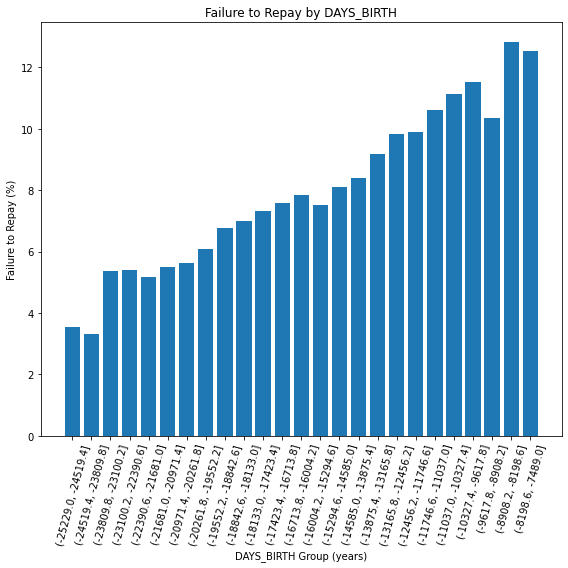

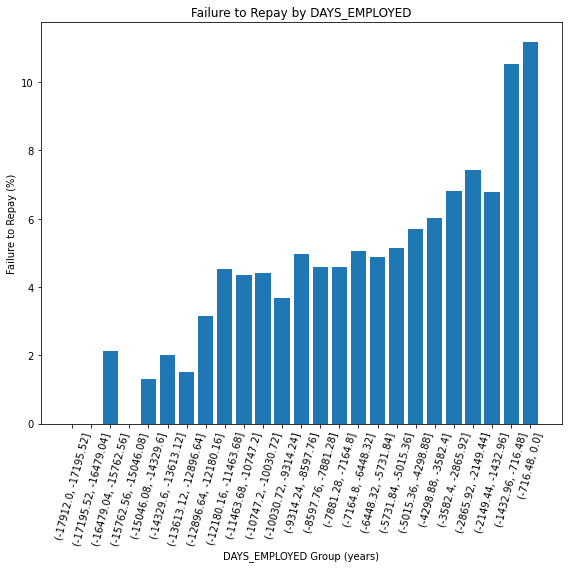

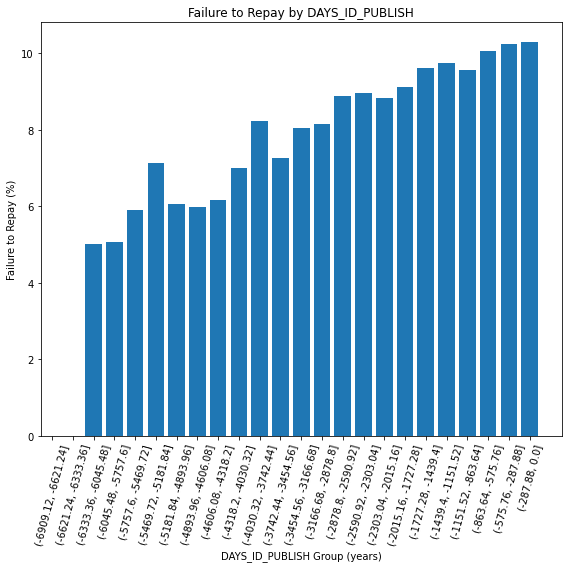

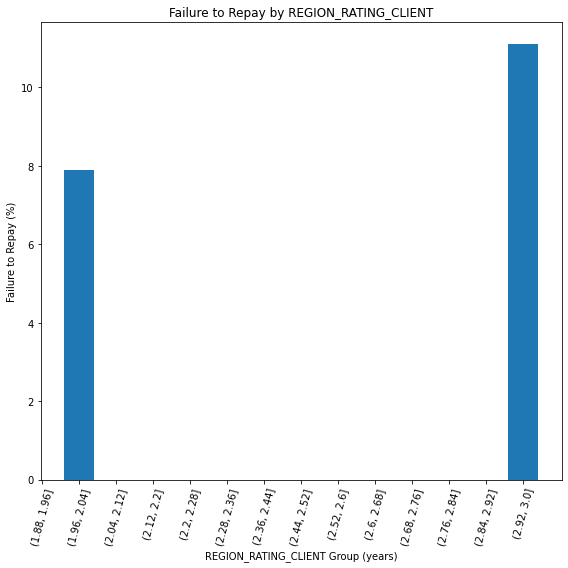

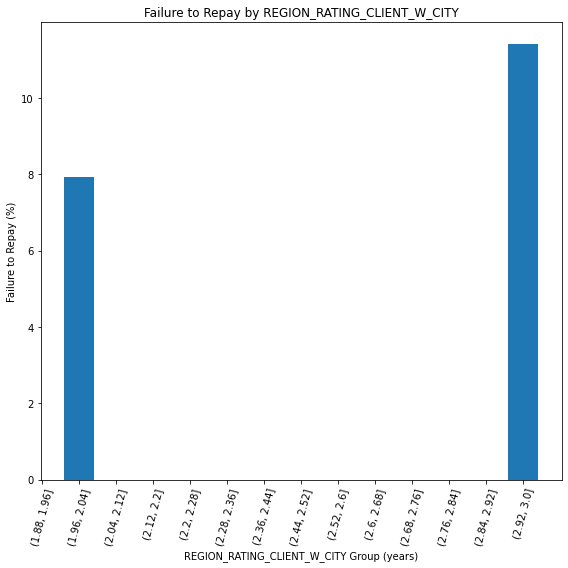

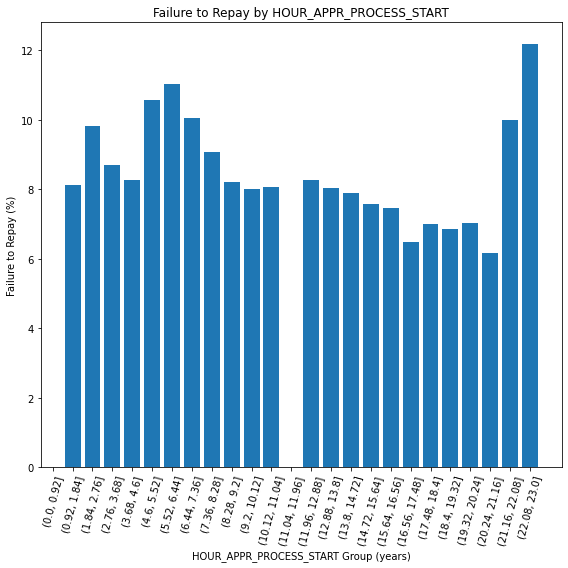

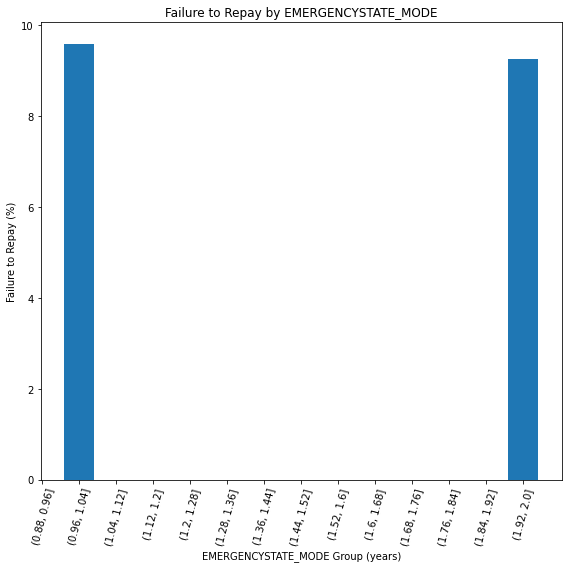

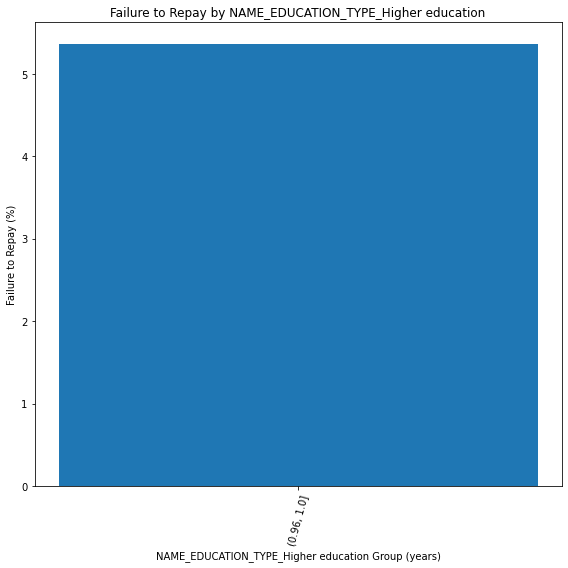

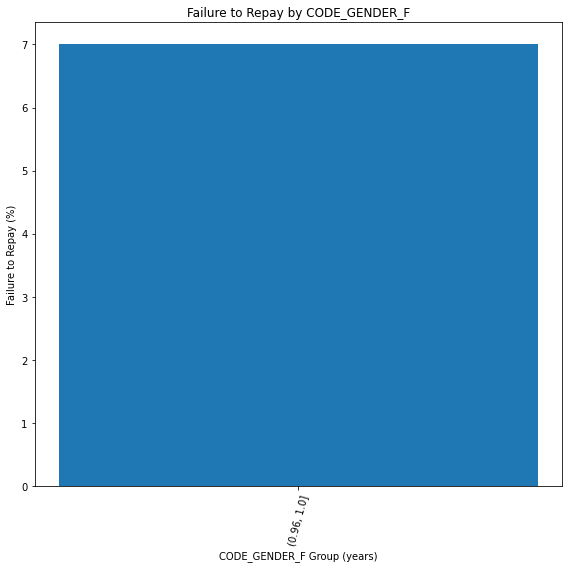

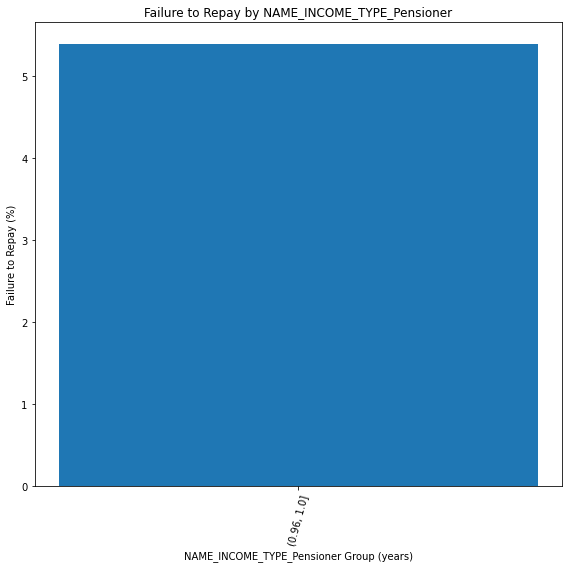

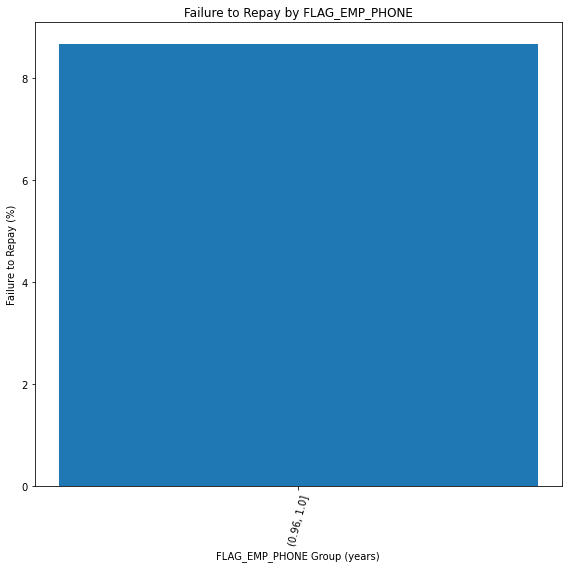

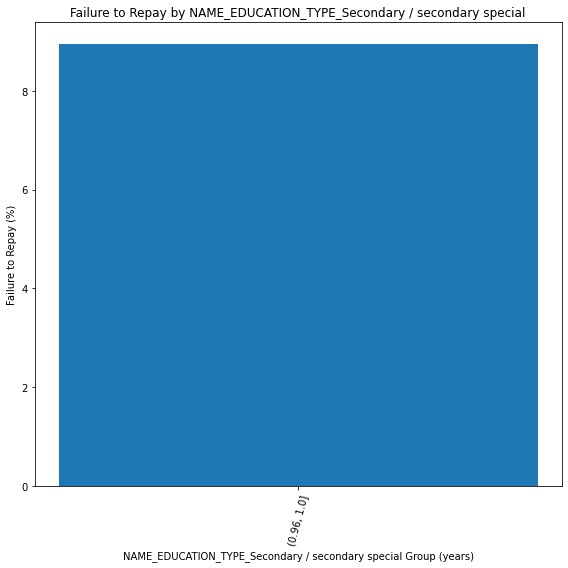

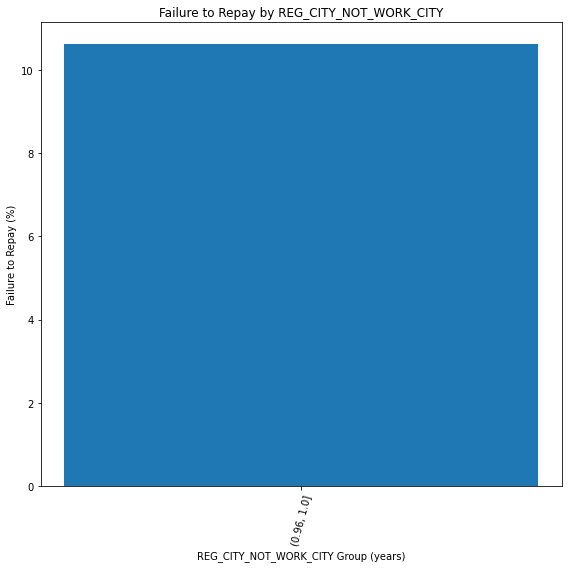

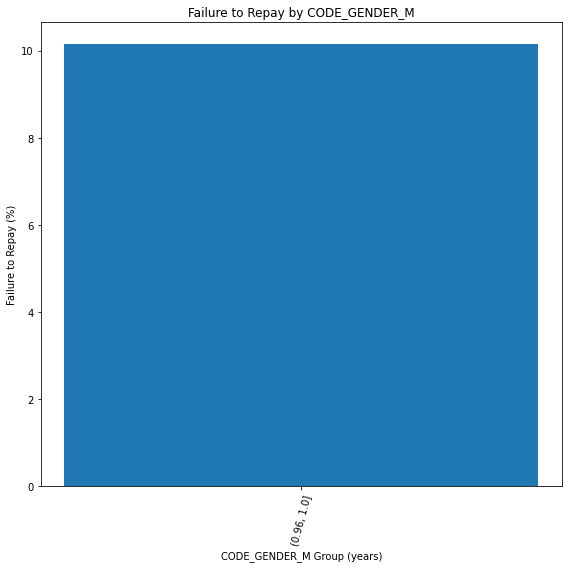

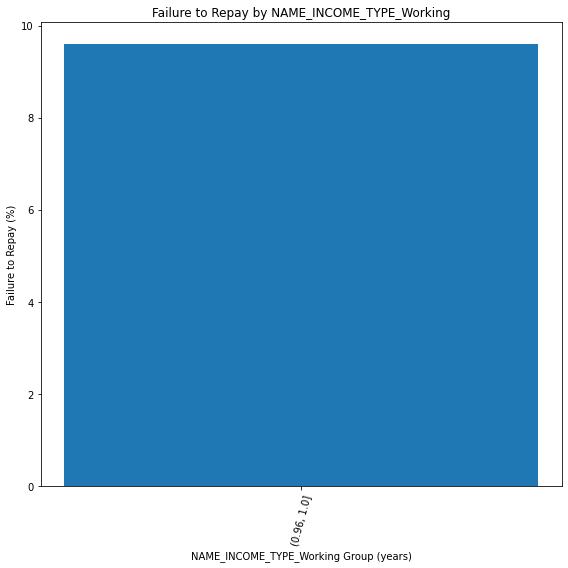

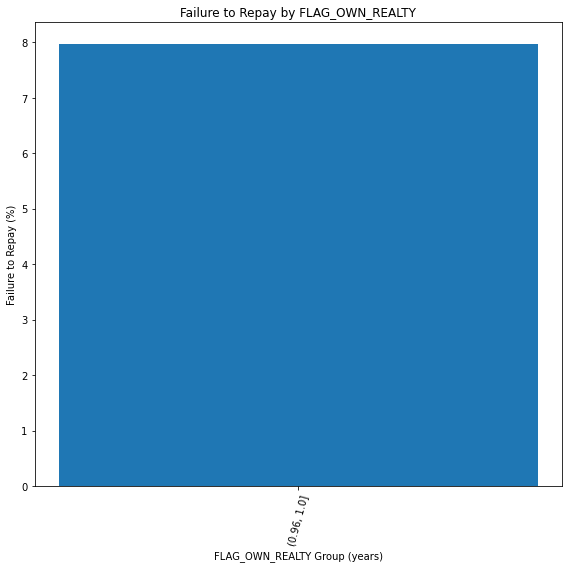

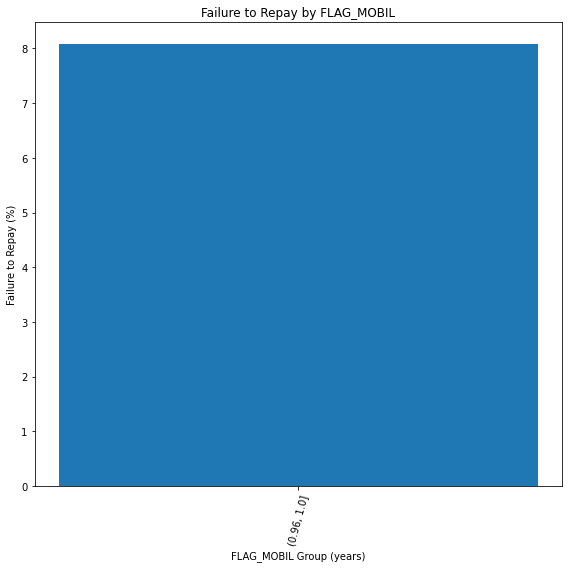

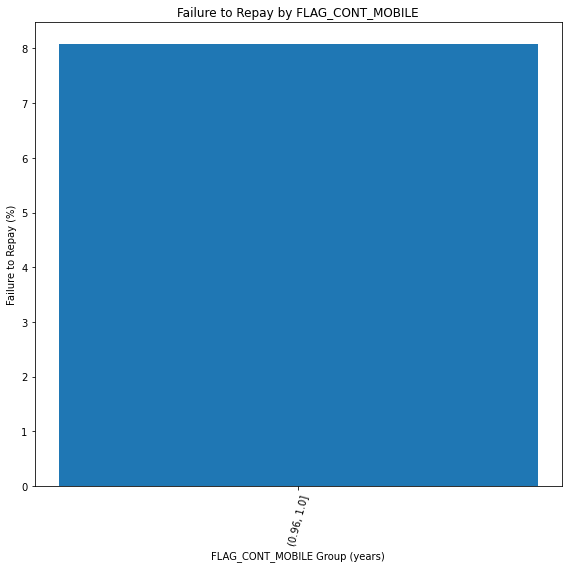

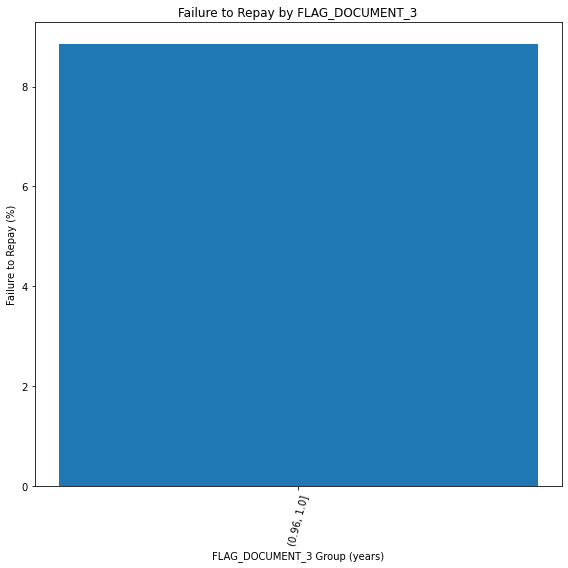

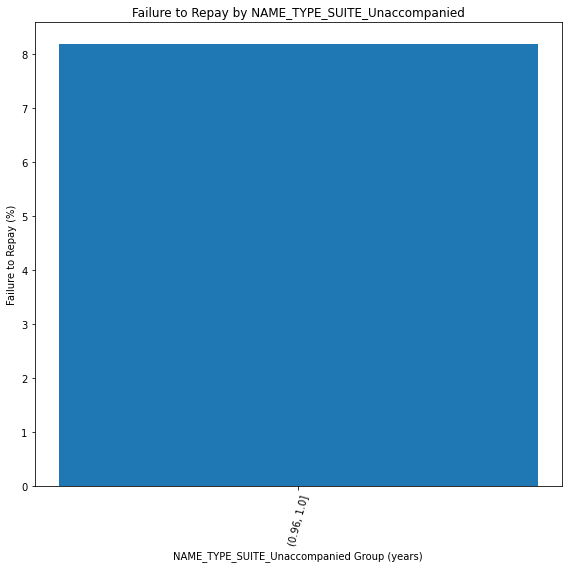

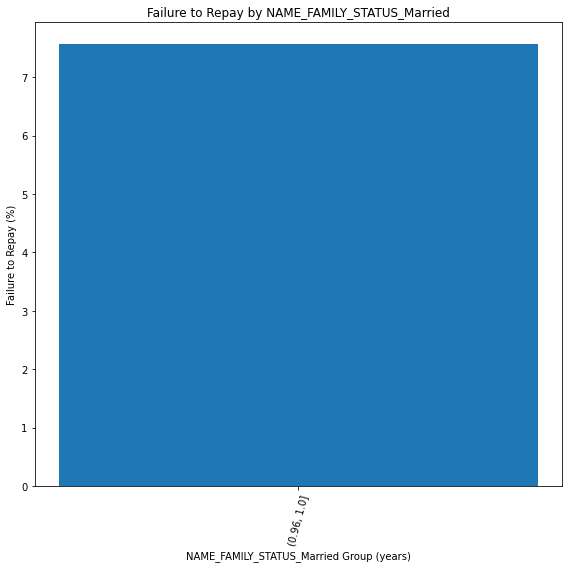

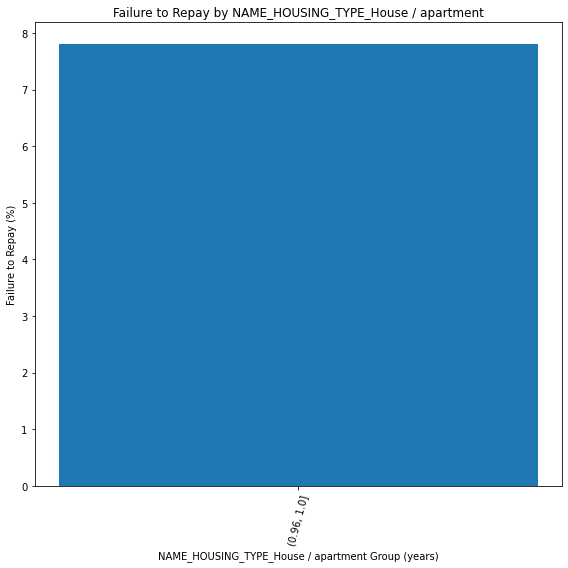

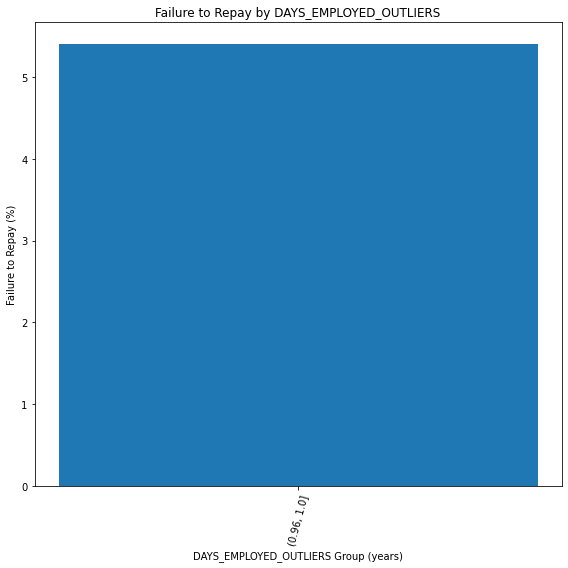

In [18]:
grouper(25)